In [4]:
import os
import sys
import requests
import warnings
import PIL
import copy

from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sb
import matplotlib
import numpy as np
from matplotlib import gridspec
import pandas as pd
import marvin.utils.plot.colorbar as colorbar
from matplotlib.colors import ListedColormap
from IPython.display import clear_output

from marvin.tools.maps import Maps
import marvin.utils.plot.map as mapplot
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.wcs import WCS
from astropy.coordinates import Distance
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import Planck15
from astropy.io import fits
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
if sys.version_info.major == 2:
    from cStringIO import StringIO as stringio
else:
    from io import StringIO as stringio
    from io import BytesIO as bytesio

matplotlib.rcParams['figure.figsize']=(10,10)
matplotlib.rcParams['font.size']=15

#sb.set_style('dark')

F:\Anaconda3\envs\iia\lib\site-packages\marvin\core\exceptions.py:55: UserWarning: cannot initiate Sentry error reporting: unknown error.
  UserWarning)
[INFO]: No release version set. Setting default to DR15


# **Legacy Cutout**

In [ ]:
class Cutout_L(object):
    """ A Generic SDSS Cutout Image

    Tool which allows to generate an image using the SDSS Skyserver
    Image Cutout service.  See http://skyserver.sdss.org/public/en/help/docs/api.aspx#imgcutout
    for details.

    Parameters:
        ra (float):
            The central Right Ascension of the cutout
        dec (float):
            The central Declination of the cutout
        width (int):
           width of cutout in arcsec
        height (int):
            height in cutout in arcsec
        scale (float):
            pixel scale in arcsec/pixel.  Default is 0.262 "/pix.
 

    Attributes:
        rawurl (str):
            The raw url of the cutout
        wcs (WCS):
            The WCS of the generated image
        image (PIL.Image):
            The cutout image object
        size (int):
            The image size in arcsec
        size_pix (int):
            The image size in pixels
        center (tuple):
            The image center RA, Dec

    """

    def __init__(self, ra, dec, width, height, layers=None, scale=None, **kwargs):
        self.rawurl = ("https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&pixscale={scale}&width={width_pix}&height={height_pix}&layer={layers}&bands=grz")
        self.ra = ra
        self.dec = dec
        self.scale = scale or 0.27  # default arcsec/pixel
        self.image = None
        self.layers = 'dr8-resid' if layers=='residual' else 'dr8'
        self.center = np.array([ra, dec])
        self.size = np.array([width, height], dtype=int)
        self.coords = {'ra': ra, 'dec': dec,
                       'width': width, 'height': height,
                       'scale': self.scale
                      ,'layers':self.layers}
        self._get_pix_size()
        if max(self.size_pix) >= 2048:
            raise MarvinError('Requested image size is too large. '
                              'The Skyserver image cutout can only return a size up to 2048 pixels')

        self._define_wcs()
        self._get_cutout(**kwargs)

    def __repr__(self):
        return ('<Cutout (ra={0}, dec={1}, scale={2}, height={3}, '
                'width={4})>,layers={5}'.format(self.ra, self.dec, self.scale, *self.size_pix))

    def _get_pix_size(self):
        """height,width converted from arcsec->pixels"""
        self.coords['height_pix'] = int(round(self.coords['height'] / self.scale))
        self.coords['width_pix'] = int(round(self.coords['width'] / self.scale))
        self.size_pix = np.array((self.coords['height_pix'], self.coords['width_pix']))

    def _define_wcs(self):
        """
        Given what we know about the scale of the image,
        define a nearly-correct world coordinate system to use with it.
        """
        w = WCS(naxis=2)
        w.wcs.crpix = self.size_pix / 2
        w.wcs.crval = self.center
        w.wcs.cd = np.array([[-1, 0], [0, 1]]) * self.scale / 3600.
        w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
        w.wcs.cunit = ['deg', 'deg']
        w.wcs.radesys = 'ICRS'
        w.wcs.equinox = 2000.0
        self.wcs = w

    def _wcs_to_dict(self):
        ''' Convert and return the WCS as a dictionary'''
        wcshdr = None
        if self.wcs:
            wcshdr = self.wcs.to_header()
            wcshdr = dict(wcshdr)
            wcshdr = {key: str(val) for key, val in wcshdr.items()}
        return wcshdr

    def _make_metadata(self, filetype=None):
        ''' Make the meta data for the image '''

        if 'png' in filetype:
            meta = PIL.PngImagePlugin.PngInfo()
        else:
            meta = None
            warnings.warn('Can only save WCS metadata with PNG filetype', MarvinUserWarning)

        if meta:
            info = {key: str(val) for key, val in self.image.info.items()}
            for row in info:
                meta.add_text(row, info[row])

        return meta

    def _update_info(self):
        ''' Update the image info dictionary '''

        for key, value in self.image.info.items():
            if isinstance(value, tuple):
                self.image.info[key] = value[0]

        wcsdict = self._wcs_to_dict()
        self.image.info = wcsdict
        self.image.info.update(self.coords)
        self.image.info['wdthpix'] = self.image.info.pop('width_pix')
        self.image.info['hghtpix'] = self.image.info.pop('height_pix')

    def _add_options(self, **kwargs):

        allowed = {'grid': 'G', 'label': 'L', 'photo': 'P', 'spectra': 'S',
                   'target': 'T', 'outline': 'O', 'bound': 'B', 'fields': 'F',
                   'masks': 'M', 'plates': 'Q', 'invert': 'I'}

        opts = []
        for key, value in kwargs.items():
            assert key in allowed.keys(), 'Cutout keyword must be one of: {0}'.format(allowed.keys())
            assert isinstance(value, (bool, type(None))), 'Cutout value can only be a Boolean'
            if value:
                opts.append(allowed[key])

        self.coords['opts'] = ''.join(opts)

    def _get_cutout(self, **kwargs):
        """ Gets an image cutout

        Get a cutout around a point, centered at some RA, Dec (in decimal
        degrees), and spanning width,height (in arcseconds) in size.

        Parameters:
            kwargs:
                Allowed keywords into the SDSS Skyserver Image Cutout

        """
        # add options
        self._add_options(**kwargs)
        # retrieve the image
        url = self.rawurl.format(**self.coords)
        response = requests.get(url)
        if not response.ok:
            print(f"\nImage not found for ra = {self.ra}, dec = {self.dec}\n" )
        else:
            base_image = response.content
            ioop = stringio if sys.version_info.major == 2 else bytesio
            self.image = PIL.Image.open(ioop(base_image))
            self._update_info()

    def save(self, filename, filetype='png'):
        ''' Save the image cutout to a file

        If the filetype is PNG, it will also save the WCS and coordinate
        information as metadata in the image.

        Parameters:
            filename (str):
                The output filename
            filetype (str):
                The output file extension
        '''

        filename, fileext = os.path.splitext(filename)
        extlist = ['.png', '.bmp', '.jpg', '.jpeg', '.tiff', '.gif', '.ppm']
        assert fileext.lower() in extlist, 'Specified filename not of allowed image type: png, gif, tiff, jpeg, bmp'

        meta = self._make_metadata(filetype=filetype)
        self.image.save(filename, filetype, pnginfo=meta)

    def show(self):
        ''' Show the image cutout '''
        if self.image:
            self.image.show()

SFRD <br>
Stellar Kinematics <br>
Mass - Metallicity <br>
Legacy DR 8<br>
Legacy DR 8 Residual

# **Data**

In [ ]:
df=pd.read_csv('Star_forming_bar.csv')
df_L=df[df.VI_morph=='Lenticular']
df_L

# **Maps I**

In [ ]:
cd sf

In [ ]:
for plateifu in ['8443-9101']:   
    if not os.path.exists(plateifu):
        os.mkdir(plateifu)
    maps = Maps(plateifu=plateifu,mode='remote')
    
# SFRD
    ha = maps.emline_gflux_ha_6564
    hb = maps.emline_gflux_hb_4862
    ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')
    mask, fig, axes = maps.get_bpt(snr_min={'ha': 5, 'nii': 3, 'oi': 1},show_plot=False)

    sf = mask['sf']['global'].astype(int) # Star forming mask
    ha_sf    = ha*sf
    hb_sf    = hb*sf
    ha_hb_sf = ha_hb*sf

    fa=ha_sf*pow(10,2.468*0.934*np.log(ha_hb_sf.value/2.86))

    t = Table.read('drpall-v2_4_3.fits', format='fits')
    z = t[t['mangaid']==maps.mangaid]['z']

    D_L = cosmo.luminosity_distance(z)

    ha_sf_dc = fa.value*(u.erg/(u.s*u.cm**2))*1e-17   # Unit conversion

    Lha = ha_sf_dc.si*4*np.pi*pow(D_L,2).si

    SFR = 5.5e-42*Lha

    SFR = SFR.value*(u.kg/u.s)

    ang_dist = Planck15.kpc_proper_per_arcmin(z).si

    area = np.pi*(ang_dist**2*maps.bin_area.to(u.rad**2)).value*(u.m**2)

    SFRD=SFR/area
    SFRD=SFRD.to(u.solMass/(u.year*u.kpc**2))
    R=maps.spx_ellcoo_elliptical_radius.value
    R_e=float(maps.header['reff'])

    x = (R/R_e)
    y = SFRD

    fig=plt.figure(figsize=(10,5))
    axn=fig.subplots(1,2)

    fig.suptitle(f"Plateifu : {plateifu} | manga id : {maps.mangaid}")
    axn[0].scatter(x,y)
    axn[0].set_xlabel(f'$R/R_e$')
    axn[0].set_ylabel(y.unit)
    axn[0].set_title('SFRD vs R')

    mapplot.plot(dapmap=ha_hb_sf,fig=fig,ax=axn[1]);
    #plt.savefig(f'{plateifu}/{plateifu} SFRD',bbox_inches = 'tight')
    plt.show()
    
# Stellar Kinematics  
    havel = maps['emline_gvel_ha_6564']
    stvel = maps['stellar_vel']

    diff = copy.deepcopy(stvel)
    diff.setfield(havel.value - stvel.value,np.float64)
    diff.ivar = 1. / ((1. / havel.ivar) + (1. / stvel.ivar))
    diff.mask = havel.mask | stvel.mask

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
                             
    fig.suptitle(f"Plateifu : {plateifu} | manga id : {maps.mangaid}")                                        
    for ax, map_ in zip(axes, [havel, stvel, diff]):
        mapplot.plot(dapmap=map_, fig=fig, ax=ax)
        if map_ is diff:
            ax.set_title('Ha vel - stellar vel')
    #plt.savefig(f'{plateifu}/{plateifu} Kinematics',bbox_inches = 'tight')
    plt.show()

    
# SDSS Cutout
    SDSS=maps.getImage()
    plt.imshow(SDSS.data)
    plt.axis('off')
    plt.title(f"Plateifu : {plateifu} | manga id : {maps.mangaid}")
   # plt.savefig(f'{plateifu}/{plateifu} SDSS Cutout',bbox_inches = 'tight')
    plt.show()
                                            
# Legacy Cutout 
    Legacy=Cutout_L(ra=SDSS.ra,dec=SDSS.dec,height=float(SDSS.header['HEIGHT']),width=float(SDSS.header['WIDTH']),scale=float(SDSS.header['SCALE']))
    plt.imshow(Legacy.image)
    plt.axis('off')
    plt.title(f"Plateifu : {plateifu} | manga id : {maps.mangaid}")
   # plt.savefig(f'{plateifu}/{plateifu} Legacy Cutout',bbox_inches = 'tight')
    plt.show()
# Legacy Residual    
    Legacy_resid=Cutout_L(ra=SDSS.ra,dec=SDSS.dec,height=float(SDSS.header['HEIGHT']),layers='residual',width=float(SDSS.header['WIDTH']),scale=float(SDSS.header['SCALE']))
    plt.imshow(Legacy_resid.image)
    plt.axis('off')
    plt.title(f"Plateifu : {plateifu} | manga id : {maps.mangaid}") 
   # plt.savefig(f'{plateifu}/{plateifu} Legacy Residual',bbox_inches = 'tight')
    plt.show()
    
    plateifu = plateifu
    mangaid  = maps.mangaid
    
# Metallicity Map
    nii = maps.emline_gflux_nii_6585
    n2 = nii/ ha
    logn2 = np.log10(n2)
    oh = 8.90 + 0.57 * logn2

    masks_bpt, __, __ = maps.get_bpt(show_plot=False)

    mask_non_sf = ~masks_bpt['sf']['global']*n2.pixmask.labels_to_value('DONOTUSE')
    mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)
    mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_ha_low_snr

    #oh.plot(title =f"Metallicity Map \n Plateifu : {plateifu} | manga id : {maps.mangaid}", cblabel='12+log(O/H)')
    mapplot.plot(dapmap=oh,mask=mask,title =f"Metallicity Map \n Plateifu : {plateifu} | manga id : {maps.mangaid}", cblabel='12+log(O/H)')
   # plt.savefig(f'{plateifu}/{plateifu} Metallicity',bbox_inches = 'tight')
    plt.show()
    

    #plateifu = plateifu.strip()
    #mangaid  = mangaid.strip()
    
    # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
    
    nii=maps.emli40ne_gflux_nii_6585
    ha=maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf = (logniiha < -0.4) & (ewha.value > 3)
    sagn = (logniiha > -0.4) & (ewha.value > 6)
    wagn = (logniiha > -0.4) & ((ewha.value > 3) & (ewha.value < 6))
    rg = ewha.value < 3
    pg = (ewha.value < 0.5) & (ewnii.value < 0.5) 

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming 
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = 6

    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    # Crop Image to match IFU size
    optical.get_new_cutout(size,size)
    gs = gridspec.GridSpec(2, 2) 

    fig=plt.figure(figsize=(18,15))

    # Optical Image
    ax1=fig.add_subplot(gs[0,0],projection=optical.wcs)
    ax1.imshow(optical.data)
    ax1.set_title('SDSS Cutout')
    optical.overlay_hexagon(ax1)
    
    # WHAN with SDSS Contours

    # WHAN IFU
    ax2=fig.add_subplot(gs[0,1],projection=maps.wcs,slices=('x','y',0))


    cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple','grey'])
    img=ax2.imshow(value,cmap=cmap,vmin=1,vmax=6)
    ax2.set_title('WHAN Diagram')
    cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.8)
    cb.set_ticks([1.4, 2.3, 3.1, 3.9, 4.8])
    cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
    ax2.set_autoscale_on(False)

    # Contour overplot
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels)
    optical.overlay_hexagon(ax2,transform=ax2.get_transform(optical.wcs),color='black')
   
    
    # Metallicity Map
    ax3 = fig.add_subplot(gs[1,0],projection=maps.wcs,slices=('x','y',0))
    linearlab, linearlab_r = colorbar.linearlab()
    mask =  mask_bad_data | mask_nii_low_snr | mask_ha_low_snr
    cb=mapplot.plot(dapmap=oh,mask=mask,return_cbrange=True)
   
    data=np.where((np.isnan(oh.value) | np.isinf(oh.value)),0,oh.value)
    
    img = ax3.imshow(data*(mask<1).astype(float)+ 0*(mask>=1).astype(float) ,cmap=linearlab,vmin=cb[0],vmax=cb[1])
    
    ax3.set_title(f"Metallicity Map  Plateifu : {plateifu} | manga id : {maps.mangaid}")
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels)
   
    optical.overlay_hexagon(ax3,transform=ax3.get_transform(optical.wcs))
   
    
    _,_,mpcb=mapplot.plot(dapmap=oh, return_cb=True)
    
    cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.8,label= '12+log(O/H)')
    cb.set_ticks(mpcb.get_ticks()[1:-1])
    
    
    # H-alpha with optical contours
    ax4 = fig.add_subplot(gs[1,1],projection=maps.wcs,slices=('x','y',0))

  
    cbrange=mapplot.plot(dapmap=ha,return_cbrange = True)
    img=ax4.imshow(ha.value,cmap=linearlab,vmin=cbrange[0],vmax=cbrange[1])
    _,_,mpcb=mapplot.plot(dapmap=ha,return_cb=True)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels)
    ax4.set_title("Emission line Gaussian flux : H-alpha 6564")
    cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.8)
    cb.set_ticks(mpcb.get_ticks()[1:-1])
    ax4.yaxis.set_label_coords(0,5)

    fig.suptitle(f"PlateIFU : {plateifu} | MaNGA ID : {mangaid}",x=0.45,y=0.92,size=20,va='top')
    optical.overlay_hexagon(ax4,transform=ax4.get_transform(optical.wcs))
    
   
    fig.savefig(f'{plateifu}/{plateifu} WHAN',bbox_inches = 'tight')

    # BPT Diagram
    mask,fig,ax=maps.get_bpt(return_figure=True,show_plot=False)
    #fig.savefig(f'{plateifu}/{plateifu} BPT',bbox_inches = 'tight')
    
    # DN 4000
    dn=maps.specindex_lo_dn4000
    fig=plt.figure(figsize=(10,12))
    ax = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    cb=mapplot.plot(dapmap=dn,return_cbrange=True)
     
    data=np.where((np.isnan(dn.value) | np.isinf(dn.value)),0,dn.value)
    
    img = ax.imshow(data*(dn.mask<1).astype(float)+ 0*(dn.mask>=1).astype(float)  ,cmap=linearlab,vmin=cb[0],vmax=cb[1])
    
    ax.set_autoscale_on(False)
    ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='red',levels=levels)
    _,_,mpcb=mapplot.plot(dapmap=dn,return_cb=True)
    optical.overlay_hexagon(ax,transform=ax.get_transform(optical.wcs))
    cb=plt.colorbar(img,ax=ax,anchor=(0,5),shrink=0.8)
    cb.set_ticks(mpcb.get_ticks()[1:-1])
    ax.set_title("Spectral Index : Dn4000")
    #fig.savefig(f'{plateifu}/{plateifu} DN4000')
    plt.pause(0.5)
    break

# **Maps II**

In [ ]:
df=np.concatenate((df_L.plateifu.values,np.array(['8083-3702','8084-6101','8335-6101','8720-1902'])))

In [ ]:
for plateifu in df:     
    try:
        maps = Maps(plateifu=plateifu,mode='remote')
        mangaid=maps.mangaid
        # Set the size of image cutout 
        scale = maps.wcs.to_header()['PC2_2']*3600
        size = 2*maps.wcs.to_header()['CRPIX1']*scale

        # Get SDSS Image
        optical=maps.getImage()

        # Crop Image to match IFU size
        optical.get_new_cutout(size,size)
        gs = gridspec.GridSpec(1,4,width_ratios=[0.8,1,1,1]) 

        fig=plt.figure(figsize=(35,8))

        # Optical Image
        ax1=fig.add_subplot(gs[0,0],projection=optical.wcs)
        ax1.imshow(optical.data)
        ax1.set_title('SDSS Cutout')
        optical.overlay_hexagon(ax1)
        filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
        levels=[60.,  90., 120., 150., 180., 210., 240.]
        
        # H-alpha with optical contours
        ax2 = fig.add_subplot(gs[0,1],projection=maps.wcs,slices=('x','y',0))
        ha = maps.emline_gflux_ha_6564

        ax2.grid(True,which='major')
        fig,ax2,cb=mapplot.plot(dapmap=ha,ax=ax2,fig=fig,return_cb=True,cbrange=[0,5])
        ax2.set_autoscale_on(False)
        ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
        cb.remove()
        cb=plt.colorbar(ax2.get_images()[1],ax=ax2,anchor=(0,5),shrink=0.85)
        ax2.set_xlabel('pos.eq.ra')
        ax2.set_ylabel('pos.eq.dec')
    

        # Metallicity Map
        ax3 = fig.add_subplot(gs[0,2],projection=maps.wcs,slices=('x','y',0))
        nii = maps.emline_gflux_nii_6585
        n2 = nii/ ha
        logn2 = np.log10(n2)
        oh = 8.90 + 0.57 * logn2

        mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
        min_snr = 3.
        mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
        mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

        mask =  mask_bad_data | mask_nii_low_snr | mask_ha_low_snr
        ax3.grid(True,which='major')
        fig,ax3,cb=mapplot.plot(dapmap=oh,mask=mask,ax=ax3,fig=fig,return_cb=True,cbrange=[8.65,8.9],title="Metallicity Map")
        ax3.set_autoscale_on(False)
        ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
        cb.remove()
        cb=plt.colorbar(ax3.get_images()[1],ax=ax3,anchor=(0,5),shrink=0.85,label= '12+log(O/H)')
        ax3.set_xlabel('pos.eq.ra')
        ax3.set_ylabel('pos.eq.dec')
        
        # DN 4000 with optical contours    
        ax4 = fig.add_subplot(gs[0,3],projection=maps.wcs,slices=('x','y',0))

        dn=maps.specindex_lo_dn4000
        ax4.grid(True,which='major')
        fig,ax4,cb=mapplot.plot(dapmap=dn,ax=ax4,fig=fig,return_cb=True,cbrange=[1,2])
        ax4.set_autoscale_on(False)
        ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
        cb.remove()
        cb=plt.colorbar(ax4.get_images()[1],ax=ax4,anchor=(0,5),shrink=0.85)
        ax4.set_xlabel('pos.eq.ra')
        ax4.set_ylabel('pos.eq.dec')
        
        fig.suptitle(f"PlateIFU : {plateifu} | MaNGA ID : {mangaid}",size=20,va='top',y=0.9)
        plt.subplots_adjust(left=0.1)
        fig.savefig(f'{plateifu} WHAN',bbox_inches = 'tight')
    except:
        continue
    plt.pause(0.5)

# **Maps III**

In [ ]:
df = pd.read_csv('MaNGA_Barred_Data_Table.csv')
df = df[df.VI_morph=='S0']

In [ ]:
download = 1
sfr_all = []
for plateifu in ['8553-12705','8600-1901','8083-3702','9049-3704','8335-6101','8946-6102','9181-9101','8551-9102']:
    if not os.path.exists(f'S0_maps/{plateifu}'):
        os.mkdir(f'S0_maps/{plateifu}')
  
    maps = Maps(plateifu=plateifu,mode='remote')
    mangaid=maps.mangaid
    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    # Optical Image
    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(projection=optical.wcs)
    ax1.imshow(optical.data)
    ax1.grid(False)
    if download:
        fig.savefig(f'S0_maps/{plateifu}/SDSS',bbox_inches = 'tight')
    
    # Crop Image to match IFU size
    optical.get_new_cutout(size,size)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    
  # H-alpha with optical contours
    fig = plt.figure(figsize = (10,10))
    ax3 = fig.add_subplot( projection=maps.wcs,slices=('x','y',0))
    ha = maps.emline_gflux_ha_6564

    ax3.grid(True,which='major')
    fig,ax3,cb=mapplot.plot(dapmap=ha,ax=ax3,fig=fig,return_cb=True,title='')
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax3.get_images()[1],ax=ax3,anchor=(0,5),shrink=0.824)
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')
    if download:
        fig.savefig(f'S0_maps/{plateifu}/H_alpha',bbox_inches = 'tight')

    # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays

    nii=maps.emli40ne_gflux_nii_6585
    ha=maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf = (logniiha < -0.4) & (ewha.value > 3)
    sagn = (logniiha > -0.4) & (ewha.value > 6)
    wagn = (logniiha > -0.4) & ((ewha.value > 3) & (ewha.value < 6))
    rg = ewha.value < 3
    pg = (ewha.value < 0.5) & (ewnii.value < 0.5) 

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming 
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = 6

    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # WHAN IFU
    fig = plt.figure(figsize = (10,10))
    ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    ax2.grid(True,which='major')
    cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
    nocov = ewha.pixmask.get_mask('NOCOV')
    fig, ax2, cb = mapplot.plot(value=value, ivar=ivar, mask=nocov, cmap=cmap,fig=fig,ax=ax2, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
    ax2.set_autoscale_on(False)

    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax2.get_images()[1],ax=ax2,anchor=(0,5),shrink=0.825)
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
    ax2.set_xlabel('pos.eq.ra')
    ax2.set_ylabel('pos.eq.dec')
    
    if download:
        fig.savefig(f'S0_maps/{plateifu}/WHAN',bbox_inches = 'tight')
    
    fig = plt.figure(figsize = (10,10))
    ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    m, f ,a = maps.get_bpt(show_plot=False)
    
    SF = sf= m['sf']['global'].astype('float64')*5
    COMP = m['comp']['global'].astype('float64')*4
    LIN = m['liner']['global'].astype('float64')*3
    SEY = m['seyfert']['global'].astype('float64')*2
    AMB = m['ambiguous']['global'].astype('float64')*1
    
    bpt = SF + COMP + LIN + SEY + AMB
    
    cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
    nocov = ewha.pixmask.get_mask('NOCOV')
    
    fig, ax4, cb = mapplot.plot(value=bpt, ivar = bpt, mask=nocov, cmap=cmap,fig=fig,ax=ax4, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
    
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
    
    cb.remove()
    cb=plt.colorbar(ax4.get_images()[1],ax=ax4,anchor=(0,5),shrink=0.825)
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')

    if download:
        fig.savefig(f'S0_maps/{plateifu}/BPT',bbox_inches = 'tight')
    plt.pause(0.05)
    
    
    fig = plt.figure(figsize = (10,10))
    ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    dn=maps.specindex_lo_dn4000
    ax4.grid(True,which='major')
    fig,ax4,cb=mapplot.plot(dapmap=dn,ax=ax4,fig=fig,return_cb=True,cbrange=[1,2],title='')
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax4.get_images()[1],ax=ax4,anchor=(0,5),shrink=0.824)
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')
    if download:
        fig.savefig(f'S0_maps/{plateifu}/DN4000',bbox_inches = 'tight')
        
    
    fig = plt.figure(figsize = (10,10))
    ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    nii = maps.emline_gflux_nii_6585
    n2 = nii/ ha
    logn2 = np.log10(n2)
    logoh = 8.90 + 0.57 * logn2

    mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

    mask =  mask_bad_data | mask_nii_low_snr | mask_ha_low_snr
    ax3.grid(True,which='major')
    fig,ax3,cb=mapplot.plot(dapmap=logoh,mask=mask,ax=ax3,fig=fig,return_cb=True,cbrange=[8.65,8.9],title='')
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax3.get_images()[1],ax=ax3,anchor=(0,5),shrink=0.825,label= '12+log(O/H)')
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')
    if download:
        fig.savefig(f'S0_maps/{plateifu}/Metallicity',bbox_inches = 'tight')
        
    
    
    hb = maps.emline_gflux_hb_4862
    ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')
    ha_sf    = ha*sf
    hb_sf    = hb*sf
    ha_hb_sf = ha_hb*sf
    
    z = maps.dapall['z']

    fa = ha_sf*pow(10,2.468*0.934*np.log(ha_hb_sf.value/2.86))

    D_L = cosmo.luminosity_distance(z).to(u.cm)

    Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)

    SFR = 5.5e-42*Lha*1e-17

    SFR = SFR.value*(u.solMass/u.year)

    ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)

    area = np.pi*(ang_dist.value**2*maps.bin_area.value)

    area = area*(u.kpc**2)

    SFRD=SFR/area

    R = maps.spx_ellcoo_elliptical_radius.value
    R_e=float(maps.header['reff'])

    x = (R/R_e)
    y = SFRD
    
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot()
    ax.scatter(x,y)
    ax.set_xlabel(r'$R/R_e$')
    ax.set_ylabel('SFRD ' + r'$M_{\odot}kpc^{-2}yr^{-1}$')
    
    if download:
        fig.savefig(f'S0_maps/{plateifu}/SFRD',bbox_inches = 'tight')
    
   # Specific SFR/ log M
    
    cube =  maps.getCube()
    M = cube.vacs.firefly._make_map('stellar_mass')
    
    mask = None
    mask = (M < -10) if not mask else mask
    masked_array = np.ma.array(M, mask=mask) #log(M)
    
    ssfr = SFR.value/10**(masked_array)
    ssfr = np.log10(ssfr)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    
    fig, ax, cb = mapplot.plot(value=ssfr, ivar = ssfr, mask=nocov, fig=fig, ax= ax,cmap='RdYlBu_r', use_masks='NOCOV', return_cb=True)
    ax.set_autoscale_on(False)
    ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11,title='')
    cb.remove()
    
    # plot the colour bar
    cbar = fig.colorbar(ax.get_images()[1], ax=ax, shrink=0.9)
    cbar.set_label(r'$log(sSFR (yr^{-1}))$', fontsize=18, labelpad=20)
    cbar.ax.tick_params(labelsize=22)
    
    ax.set_xlabel('pos.eq.ra')
    ax.set_ylabel('pos.eq.dec')
    
    if download:
        fig.savefig(f'S0_maps/{plateifu}/sSFR',bbox_inches = 'tight')
    
    
    x = masked_array
    y = ssfr
    sfr_all.append([x,y])
     
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot()
    ax.scatter(x,y)
    ax.set_xlabel(r'$\log(M/M_{\odot})$')
    ax.set_ylabel(r'$\log(sSFR (yr^{-1}))$')
    
    if download:
        fig.savefig(f'S0_maps/{plateifu}/sSFRvM',bbox_inches = 'tight')

    # OIII/OII map
    OIII_OII= maps.getMapRatio('emline_gflux','oiii_5008','oii_3729')
    
    fig = plt.figure(figsize = (10,10))
    
    ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    ax4.grid(True,which='major')
    fig,ax4,cb = mapplot.plot(dapmap = OIII_OII, ax = ax4, fig = fig,return_cb = True,title='')
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform = ax4.get_transform(optical.wcs), colors = 'red',levels = levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax4.get_images()[1],ax=ax4,anchor=(0,5),shrink=0.824)
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')
    if download:
        fig.savefig(f'S0_maps/{plateifu}/OIII_OII',bbox_inches = 'tight')
        
     # H alpha EW
    ewha = maps['emline_sew_ha_6564']
    fig = plt.figure(figsize = (10,10))
    ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    ax2.grid(True,which='major')
    fig,ax2,cb=mapplot.plot(dapmap=ewha,ax=ax2,fig=fig,return_cb=True)
    ax2.set_autoscale_on(False)
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='red',levels=levels,zorder=11,title='')
    cb.remove()
    cb=plt.colorbar(ax2.get_images()[1],ax=ax2,anchor=(0,5),shrink=0.86)
    ax2.set_xlabel('pos.eq.ra')
    ax2.set_ylabel('pos.eq.dec')
    
    if download:
        fig.savefig(f'S0_maps/{plateifu}/ewH_alpha',bbox_inches = 'tight')
        
    # OIII 5007 EW
    ewOIII = maps['emline_sew_oiii_5008']
    fig = plt.figure(figsize = (10,10))
    ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    ax3.grid(True,which='major')
    fig,ax3,cb = mapplot.plot(dapmap = ewOIII , ax = ax3, fig = fig,return_cb = True,title='')
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform = ax3.get_transform(optical.wcs), colors = 'red',levels = levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax3.get_images()[1],ax=ax3,anchor=(0,5),shrink=0.824)
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')
    
    if download:
        fig.savefig(f'S0_maps/{plateifu}/ewOIII',bbox_inches = 'tight')

In [ ]:
for x,y in sfr_all:
    plt.scatter(x,y,c=y,marker='.')
plt.show()

In [ ]:
M = cube.vacs.firefly._make_map('stellar_mass')
mask = None
mask = (M < -10) if not mask else mask
masked_array = np.ma.array(M, mask=mask)
fig, ax, cb = mapplot.plot(value=masked_array, ivar = masked_array, mask=nocov, cmap='RdYlBu_r',fig=fig, use_masks='NOCOV', return_cb=True)
fig

In [ ]:
plt.plot(SFR.value);

In [ ]:
for plateifu in s:

    maps = Maps(plateifu=plateifu,mode='remote')
    mangaid=maps.mangaid
    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    # Crop Image to match IFU size
    optical.get_new_cutout(size,size)
    gs = gridspec.GridSpec(1,5,width_ratios=[0.8,1,1,1,1]) 

    fig=plt.figure(figsize=(50,9))

    # Optical Image
    ax1=fig.add_subplot(gs[0,0],projection=optical.wcs)
    ax1.imshow(optical.data)
    ax1.set_title('SDSS Cutout')
    optical.overlay_hexagon(ax1)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]


    # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays

    nii=maps.emli40ne_gflux_nii_6585
    ha=maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf = (logniiha < -0.4) & (ewha.value > 3)
    sagn = (logniiha > -0.4) & (ewha.value > 6)
    wagn = (logniiha > -0.4) & ((ewha.value > 3) & (ewha.value < 6))
    rg = ewha.value < 3
    pg = (ewha.value < 0.5) & (ewnii.value < 0.5) 

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming 
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = 6

    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # WHAN IFU

    ax2=fig.add_subplot(gs[0,1],projection=maps.wcs,slices=('x','y',0))
    ax2.grid(True,which='major')
    cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
    nocov = ewha.pixmask.get_mask('NOCOV')
    fig, ax2, cb = mapplot.plot(value=value, ivar=ivar, mask=nocov, cmap=cmap,fig=fig,ax=ax2, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='WHAN Diagram')
    ax2.set_autoscale_on(False)

    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax2.get_images()[1],ax=ax2,anchor=(0,5),shrink=0.86)
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
    ax2.set_xlabel('pos.eq.ra')
    ax2.set_ylabel('pos.eq.dec')


    # H-alpha with optical contours
    ax3 = fig.add_subplot(gs[0,2],projection=maps.wcs,slices=('x','y',0))
    ha = maps.emline_gflux_ha_6564

    ax3.grid(True,which='major')
    fig,ax3,cb=mapplot.plot(dapmap=ha,ax=ax3,fig=fig,return_cb=True)
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax3.get_images()[1],ax=ax3,anchor=(0,5),shrink=0.86)
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')




    # Metallicity Map
    ax3 = fig.add_subplot(gs[0,3],projection=maps.wcs,slices=('x','y',0))
    nii = maps.emline_gflux_nii_6585
    n2 = nii/ ha
    logn2 = np.log10(n2)
    oh = 8.90 + 0.57 * logn2

    mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

    mask =  mask_bad_data | mask_nii_low_snr | mask_ha_low_snr
    ax3.grid(True,which='major')
    fig,ax3,cb=mapplot.plot(dapmap=oh,mask=mask,ax=ax3,fig=fig,return_cb=True,cbrange=[8.65,8.9],title='Metallicity Map')
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax3.get_images()[1],ax=ax3,anchor=(0,5),shrink=0.82,label= '12+log(O/H)')
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')

    # DN 4000 with optical contours    
    ax4 = fig.add_subplot(gs[0,4],projection=maps.wcs,slices=('x','y',0))

    dn=maps.specindex_lo_dn4000
    ax4.grid(True,which='major')
    fig,ax4,cb=mapplot.plot(dapmap=dn,ax=ax4,fig=fig,return_cb=True,cbrange=[1,2])
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax4.get_images()[1],ax=ax4,anchor=(0,5),shrink=0.82)
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')

    fig.suptitle(f"Plateifu : {plateifu}",x=0.49,y=0.88,size=20,va='top')
    
    
    fig.savefig(f'img1/{plateifu}ap',bbox_inches = 'tight')

In [ ]:
ssfr_all

In [ ]:
os.path.exists('EL')

# **Maps IV**

In [ ]:
for plateifu in ['8083-3702','8138-6102','8309-6101','8331-6104','8335-6101','8484-3702','8553-12705','8946-6102','9490-3701','9888-3701']:
    if not os.path.exists(plateifu):
        os.mkdir(plateifu)    
    
    maps = Maps(plateifu=plateifu)
    mangaid=maps.mangaid
    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale
    # Get SDSS Image
    optical=maps.getImage()

    # Crop Image to match IFU size
    optical.get_new_cutout(size,size)
    gs = gridspec.GridSpec(2,3) 

    fig=plt.figure(figsize=(22,11))

    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]

    # H-alpha with optical contours
    ax1 = fig.add_subplot(gs[0,0],projection=maps.wcs,slices=('x','y',0))
    ha = maps.emline_gflux_ha_6564

    ax1.grid(True,which='major')
    fig,ax1,cb=mapplot.plot(dapmap=ha,ax=ax1,fig=fig,return_cb=True)
    ax1.set_autoscale_on(False)
    ax1.contour(filter_r, transform=ax1.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax1.get_images()[1],ax=ax1,anchor=(0,5),shrink=0.86)
    ax1.set_xlabel('pos.eq.ra')
    ax1.set_ylabel('pos.eq.dec')
    
    # H alpha EW
    ewha = maps['emline_sew_ha_6564']
    
    ax2 = fig.add_subplot(gs[0,1],projection=maps.wcs,slices=('x','y',0))

    ax2.grid(True,which='major')
    fig,ax2,cb=mapplot.plot(dapmap=ewha,ax=ax2,fig=fig,return_cb=True)
    ax2.set_autoscale_on(False)
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax2.get_images()[1],ax=ax2,anchor=(0,5),shrink=0.86)
    ax2.set_xlabel('pos.eq.ra')
    ax2.set_ylabel('pos.eq.dec')
    
    # OIII 5007 EW
    ewOIII = maps['emline_sew_oiii_5008']
    
    ax3 = fig.add_subplot(gs[0,2],projection=maps.wcs,slices=('x','y',0))

    ax3.grid(True,which='major')
    fig,ax3,cb = mapplot.plot(dapmap = ewOIII , ax = ax3, fig = fig,return_cb = True)
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform = ax3.get_transform(optical.wcs), colors = 'red',levels = levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax3.get_images()[1],ax=ax3,anchor=(0,5),shrink=0.86)
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')
    
    # OIII/OII map
    OIII_OII= maps.getMapRatio('emline_gflux','oiii_5008','oii_3729')
    
    ax4 = fig.add_subplot(gs[1,0],projection=maps.wcs,slices=('x','y',0))

    ax4.grid(True,which='major')
    fig,ax4,cb = mapplot.plot(dapmap = OIII_OII, ax = ax4, fig = fig,return_cb = True,title='OIII/OII')
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform = ax4.get_transform(optical.wcs), colors = 'red',levels = levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax4.get_images()[1],ax=ax4,anchor=(0,5),shrink=0.86)
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')
    

    # Metallicity Map
    ax5 = fig.add_subplot(gs[1,1],projection=maps.wcs,slices=('x','y',0))
    nii = maps.emline_gflux_nii_6585
    n2 = nii/ ha
    logn2 = np.log10(n2)
    oh = 8.90 + 0.57 * logn2

    mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

    mask =  mask_bad_data | mask_nii_low_snr | mask_ha_low_snr
    ax5.grid(True,which='major')
    fig,ax5,cb=mapplot.plot(dapmap=oh,mask=mask,ax=ax5,fig=fig,return_cb=True,cbrange=[8.65,8.9],title='Metallicity Map')
    ax5.set_autoscale_on(False)
    ax5.contour(filter_r, transform=ax5.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax5.get_images()[1],ax=ax5,anchor=(0,5),shrink=0.82,label= '12+log(O/H)')
    ax5.set_xlabel('pos.eq.ra')
    ax5.set_ylabel('pos.eq.dec')

    # DN 4000 with optical contours    
    ax6 = fig.add_subplot(gs[1,2],projection=maps.wcs,slices=('x','y',0))

    dn = maps.specindex_dn4000
    ax6.grid(True,which='major')
    fig,ax6,cb=mapplot.plot(dapmap=dn,ax=ax6,fig=fig,return_cb=True,cbrange=[1,2])
    ax6.set_autoscale_on(False)
    ax6.contour(filter_r, transform=ax6.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb.remove()
    cb=plt.colorbar(ax6.get_images()[1],ax=ax6,anchor=(0,5),shrink=0.82)
    ax6.set_xlabel('pos.eq.ra')
    ax6.set_ylabel('pos.eq.dec')

    fig.suptitle(" ",size=20,va='top',y=0.9)
    plt.subplots_adjust(left=0.1)
    fig.savefig(f'{plateifu}/{plateifu}maps',bbox_inches = 'tight')
    
    mask,fig,ax=maps.get_bpt(return_figure=True,show_plot=False)
    fig.savefig(f'{plateifu}/{plateifu} BPT',bbox_inches = 'tight')
    
    img = maps.getImage()
    
    img.save(f'{plateifu}/{plateifu}sdss.png',filetype='png')
    
    plt.pause(0.5)

In [ ]:
maps.datamodel

# **Maps V**

In [1]:
use_masks = ['NOCOV','LOWCOV','DEADFIBER','FORESTAR','NOVALUE','UNRELIABLE','MATHERROR','FITFAILED','NOCORRECTION','MULTICOMP','NEARBOUND','DONOTUSE']
def goodspax(dapmap):
    bad_data = dapmap.pixmask.get_mask(use_masks,dtype = np.bool)
    low_snr = dapmap.value*np.sqrt(dapmap.ivar)<1.0
    mask = np.logical_or.reduce((bad_data, low_snr))
    mask = np.where(mask==True,np.nan,1)
    return dapmap.value*mask


In [2]:
['8083-3702','8553-12705','8600-1901','9049-3704','8335-6101','8946-6102','9181-9101','8551-9102']

['8083-3702',
 '8553-12705',
 '8600-1901',
 '9049-3704',
 '8335-6101',
 '8946-6102',
 '9181-9101',
 '8551-9102']

[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]:  (MatplotlibDeprecationWarning)


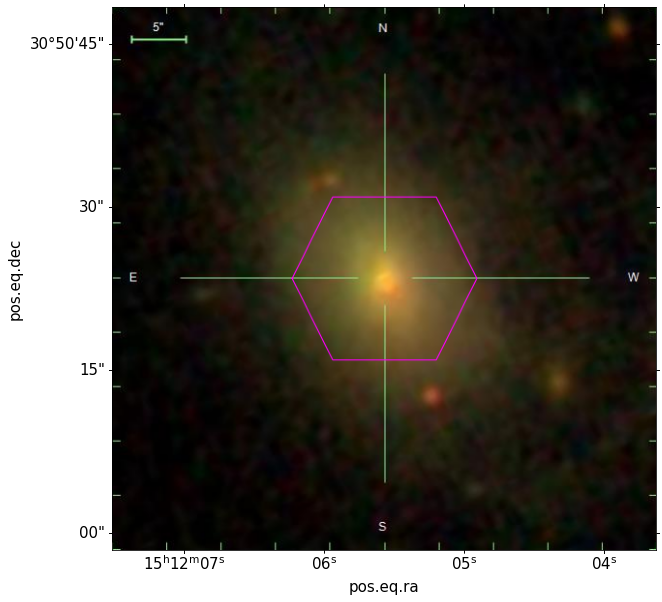

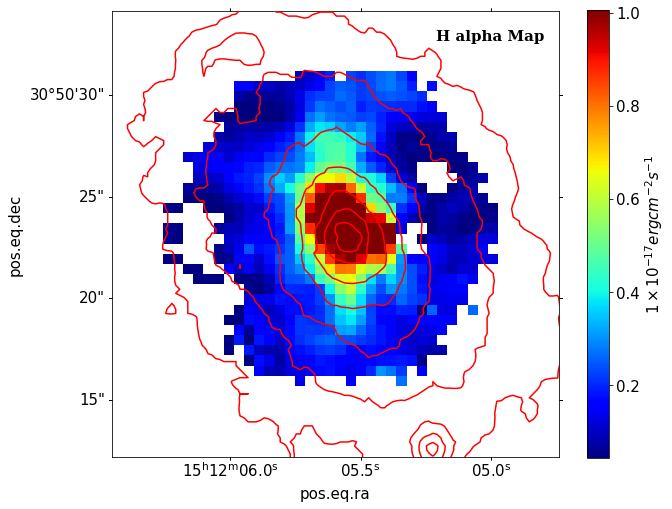

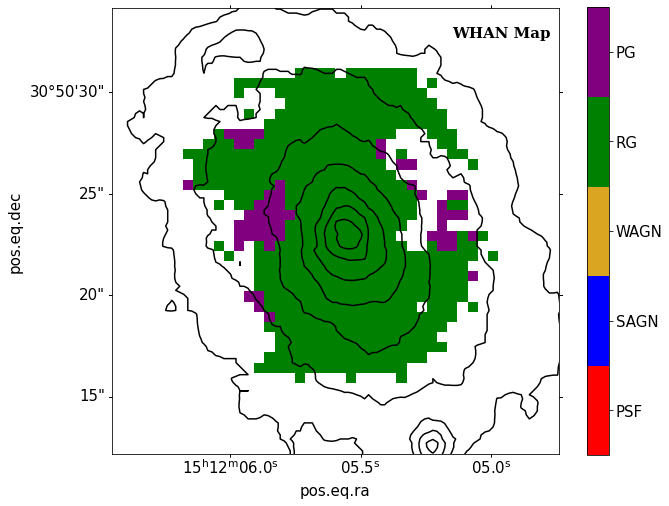

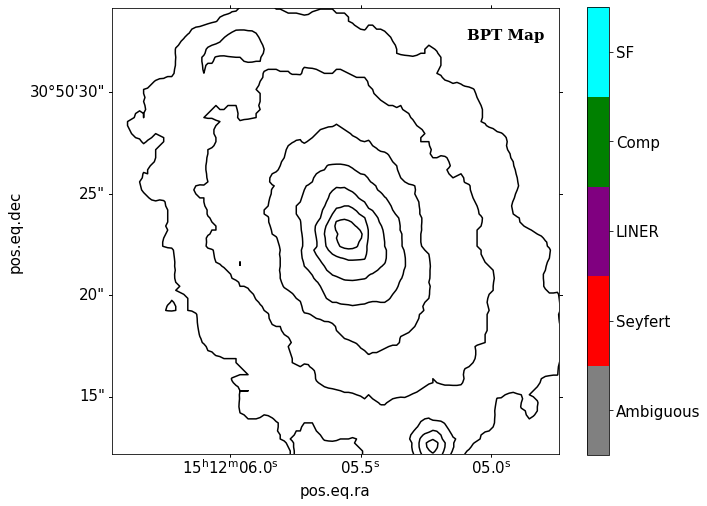

[WARNING]: divide by zero encountered in power (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]:  (MatplotlibDeprecationWarning)


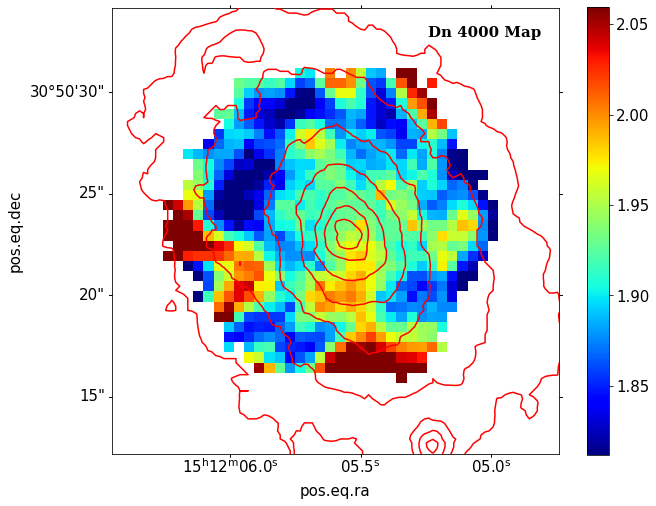

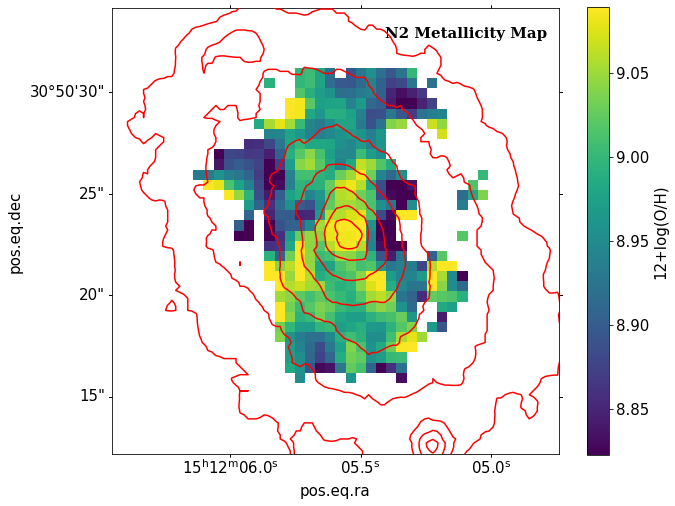

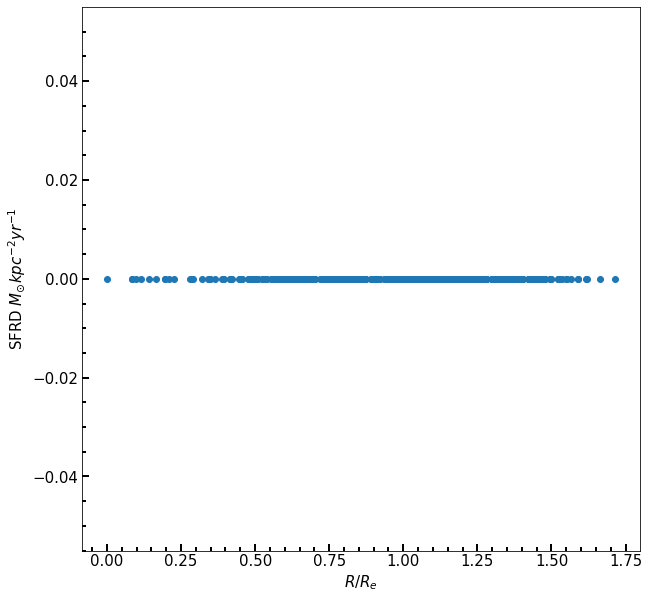

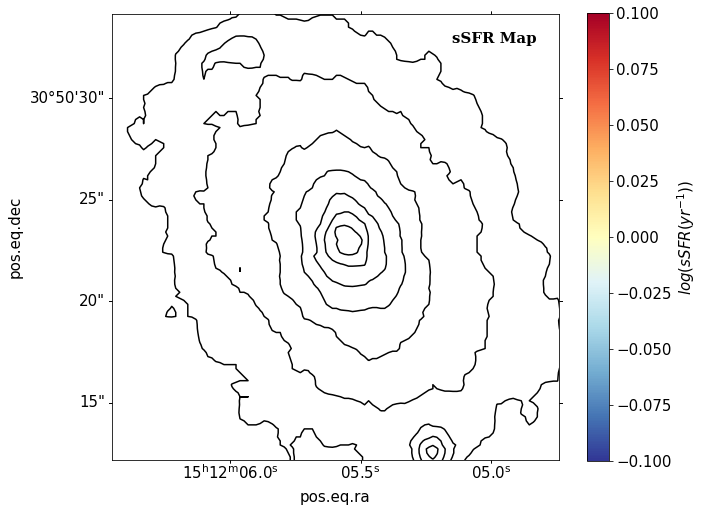

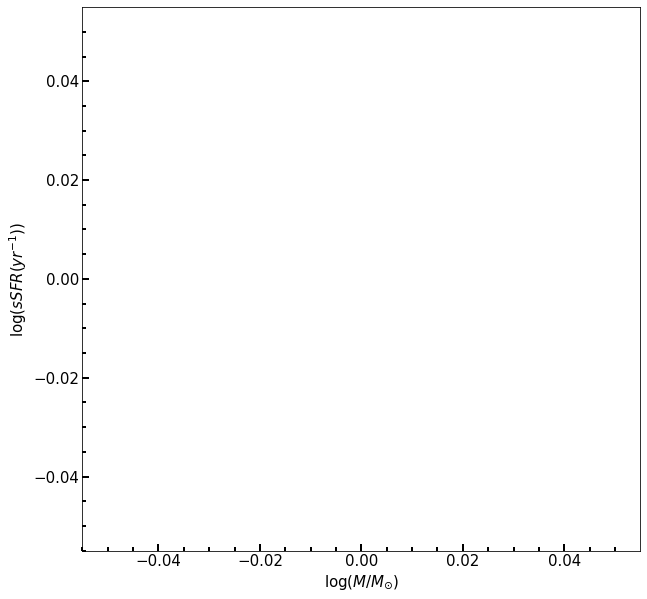

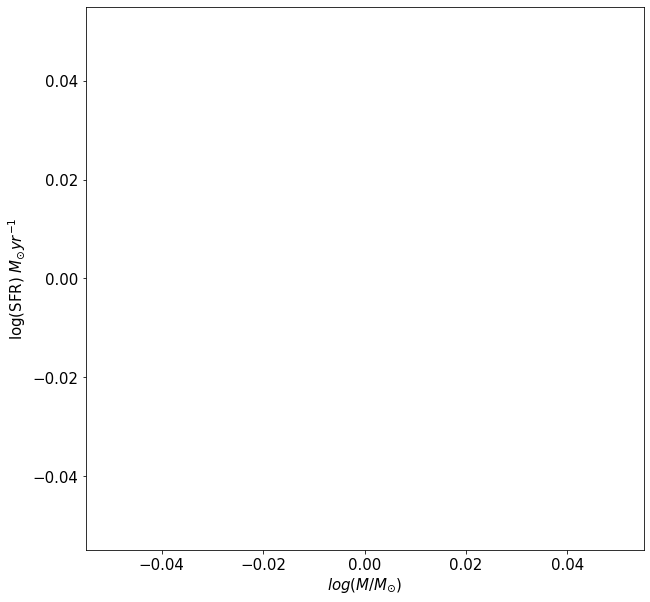

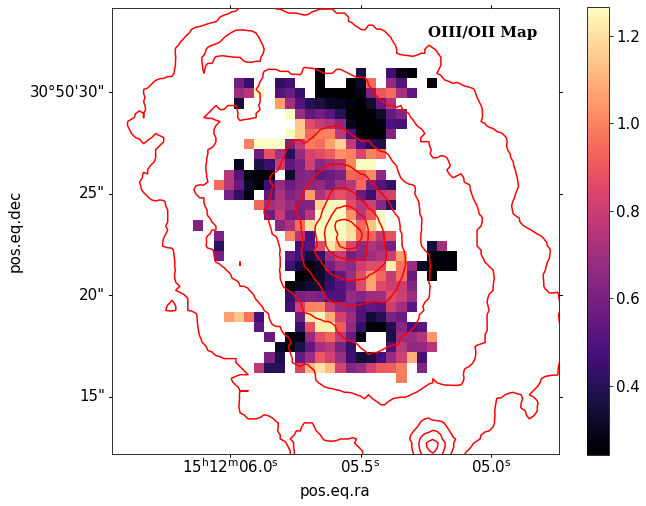

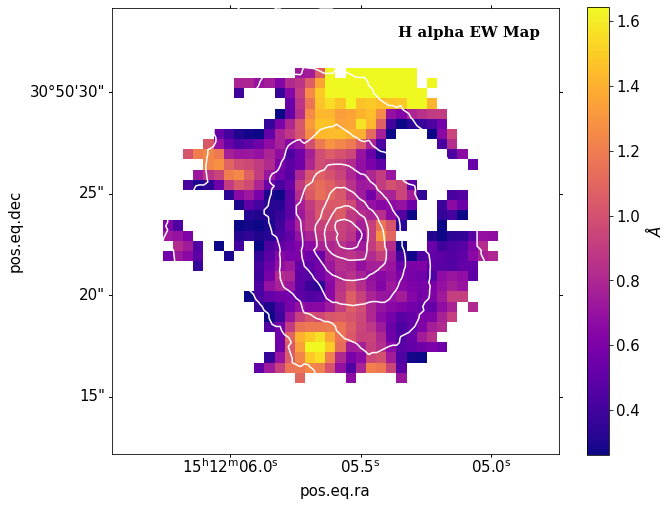

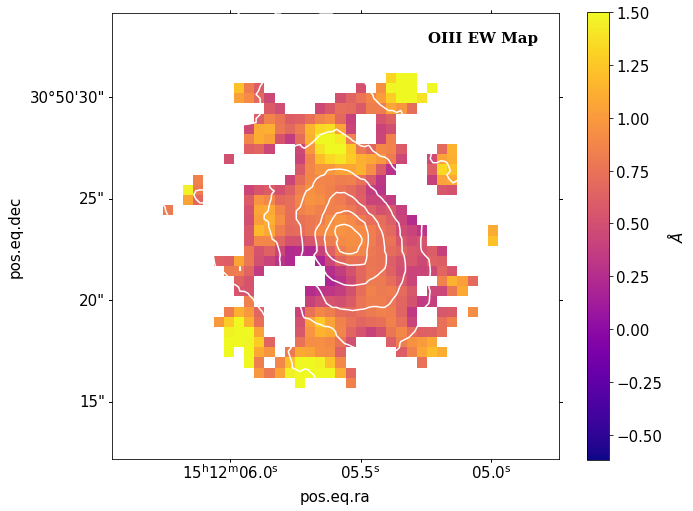

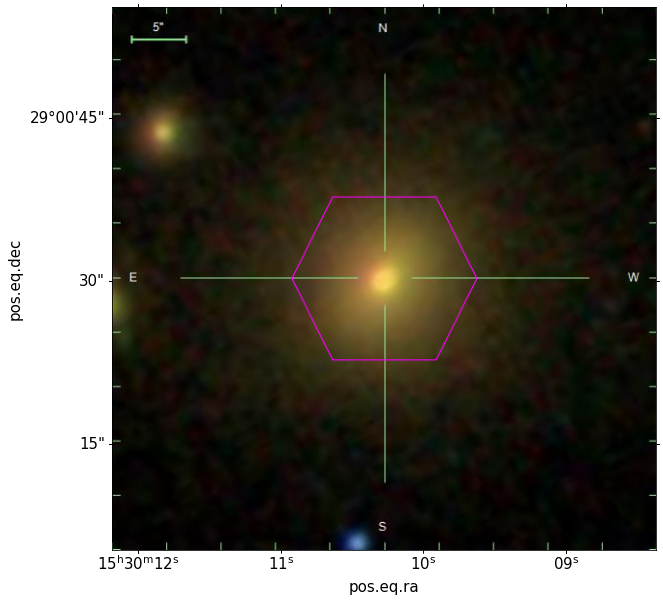

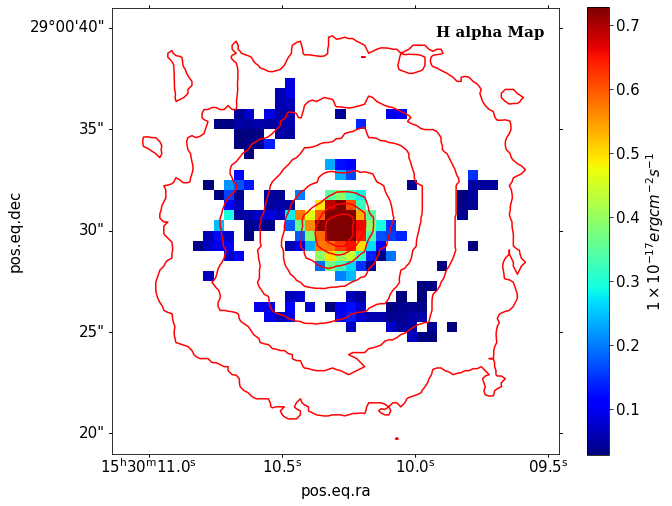

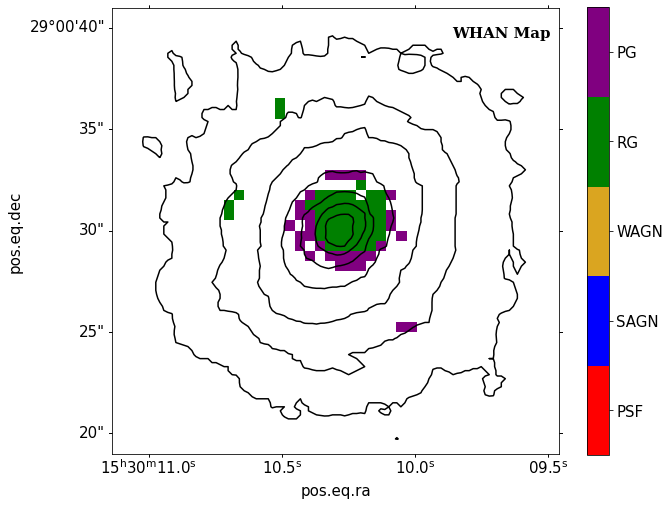

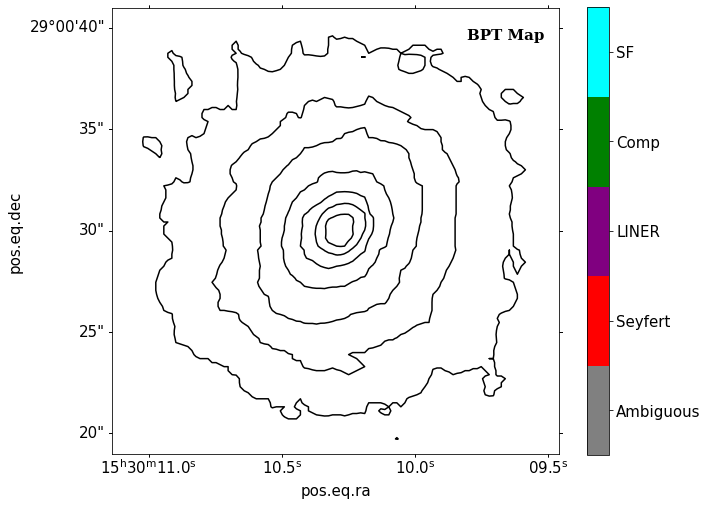

[WARNING]: divide by zero encountered in power (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]:  (MatplotlibDeprecationWarning)


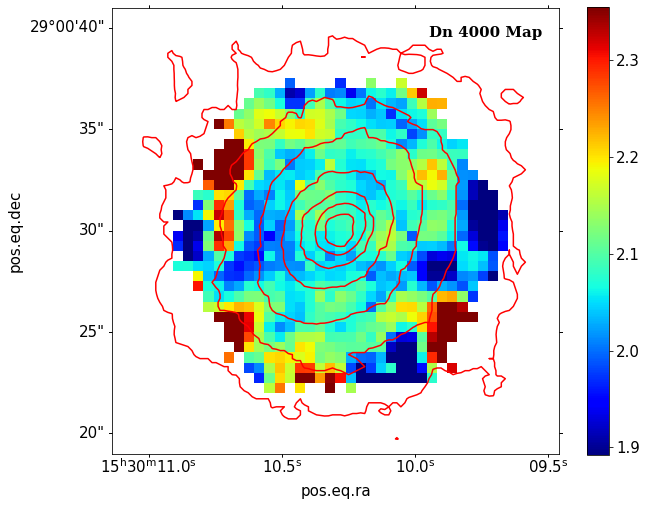

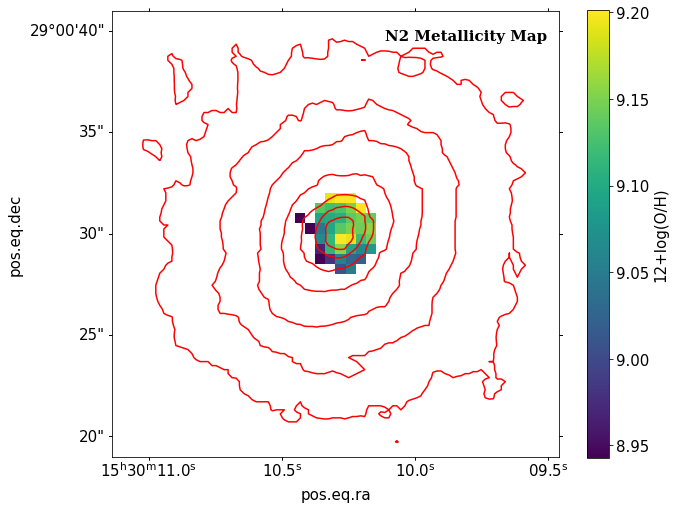

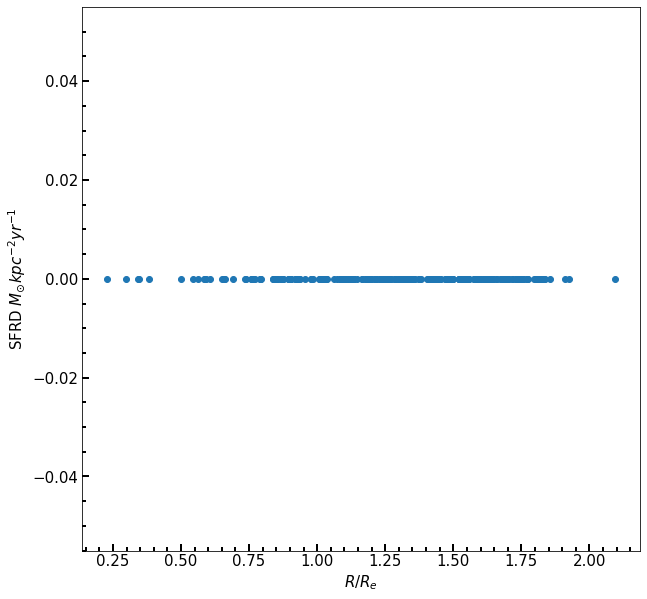

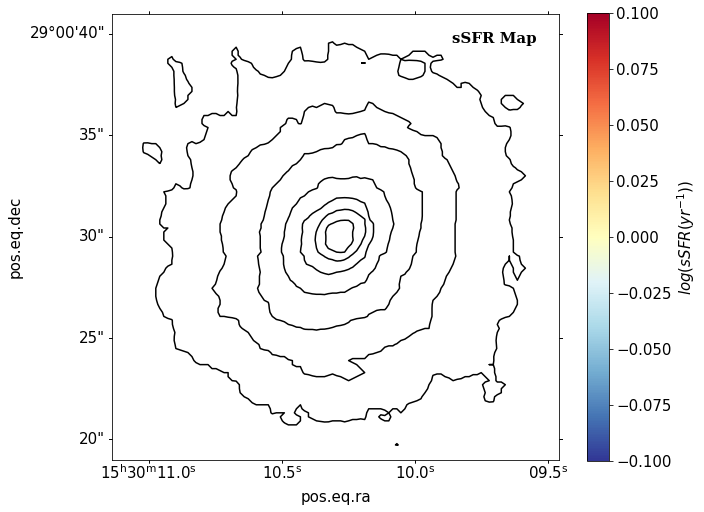

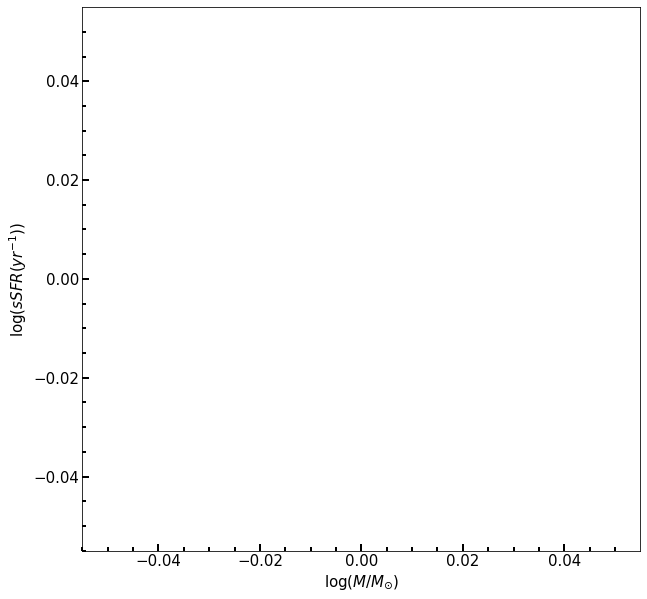

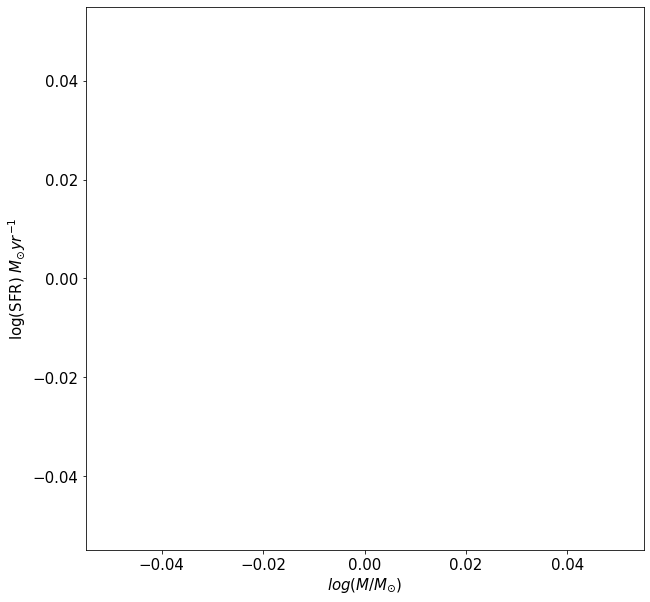

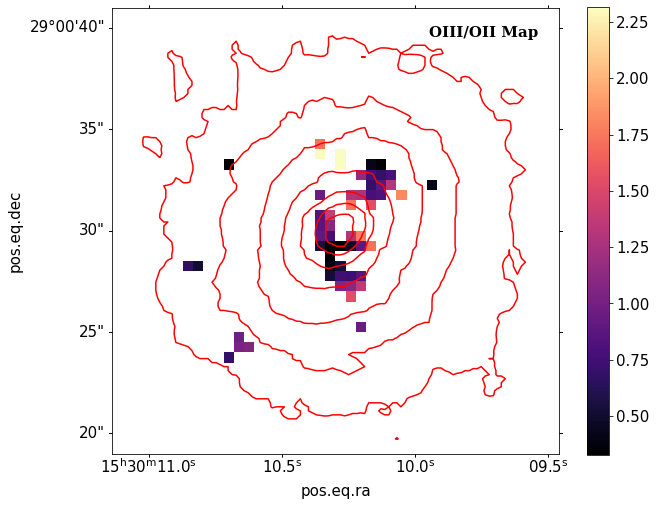

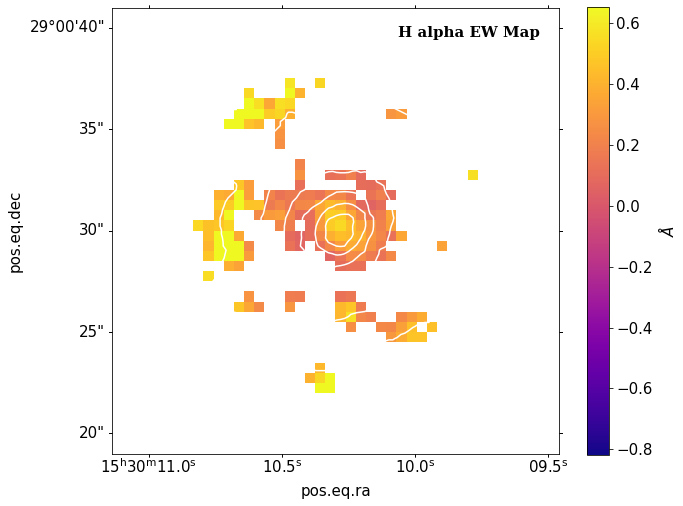

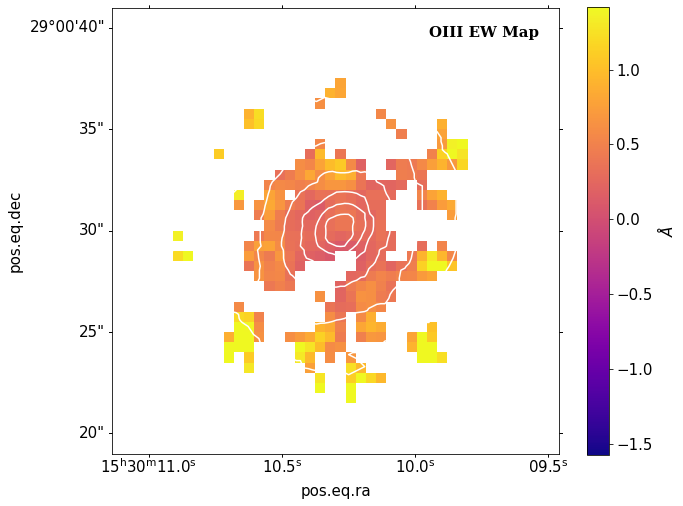

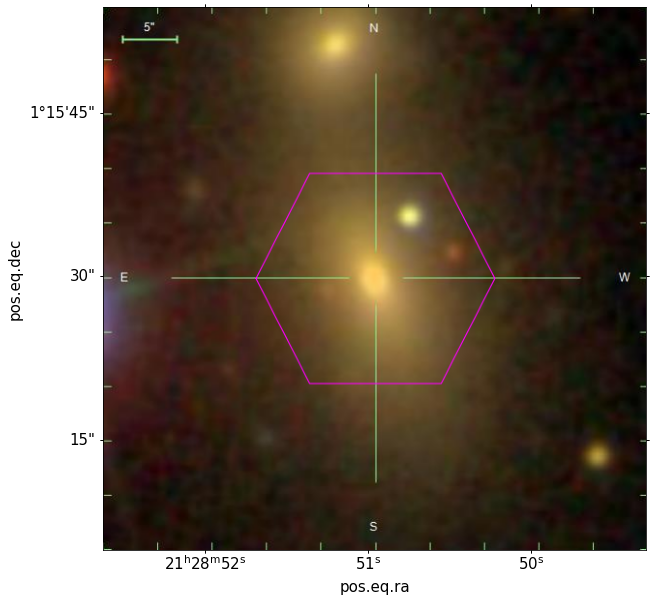

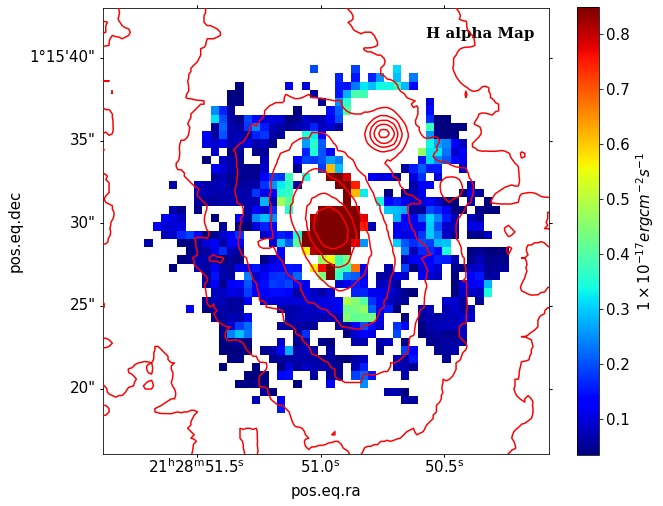

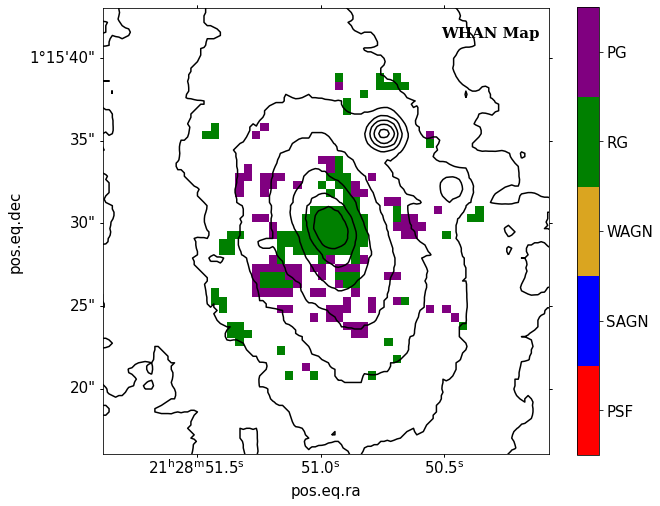

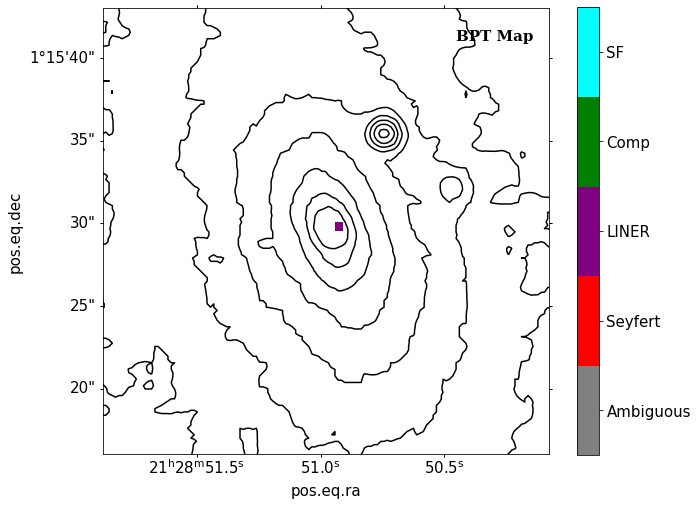

[WARNING]: divide by zero encountered in power (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: divide by zero encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)
[WARNING]: invalid value encountered in multiply (RuntimeWarning)


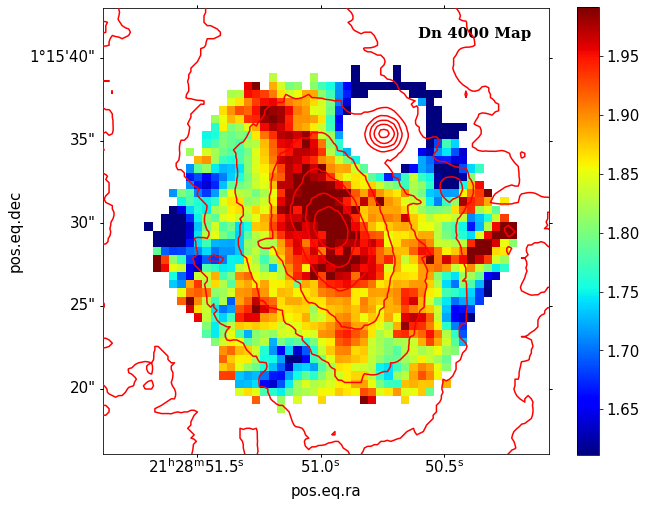

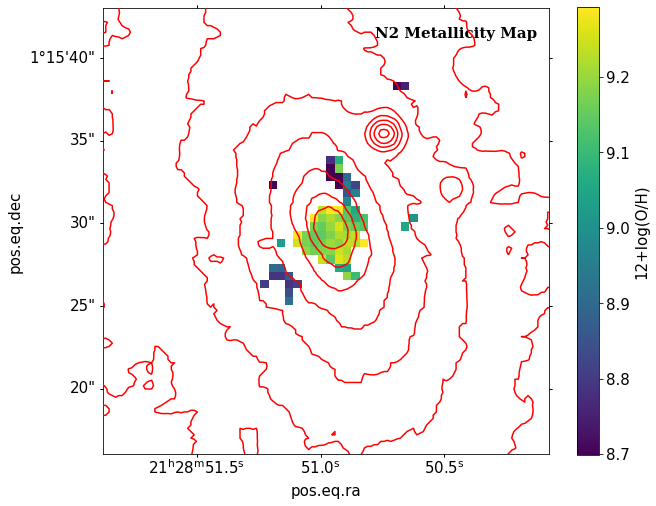

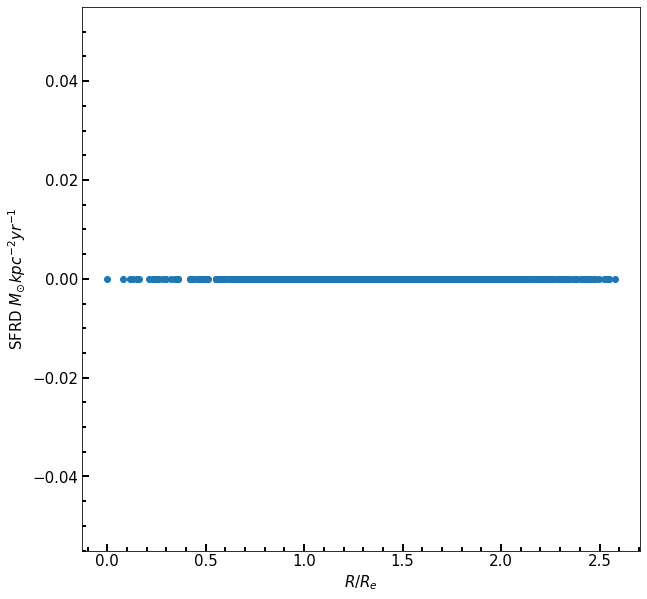

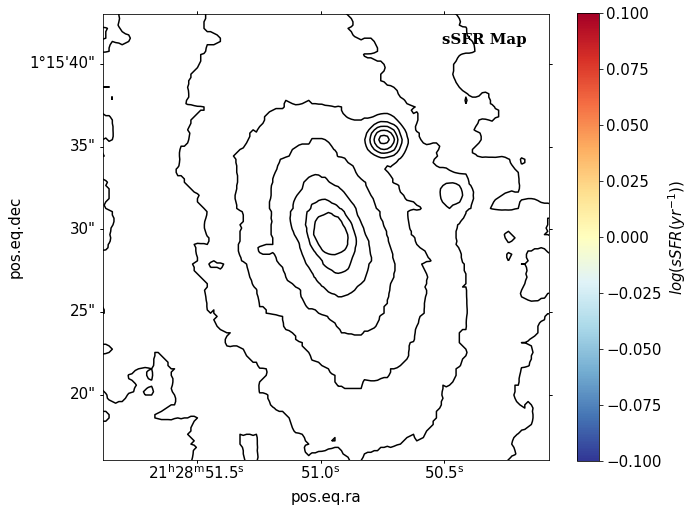

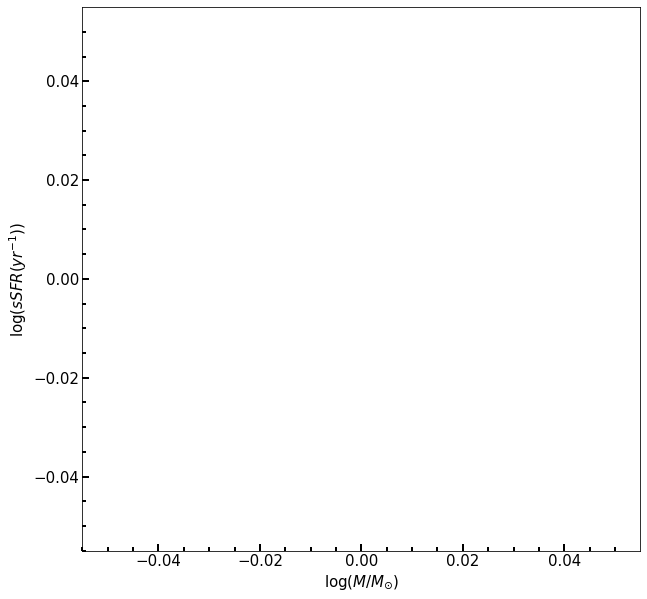

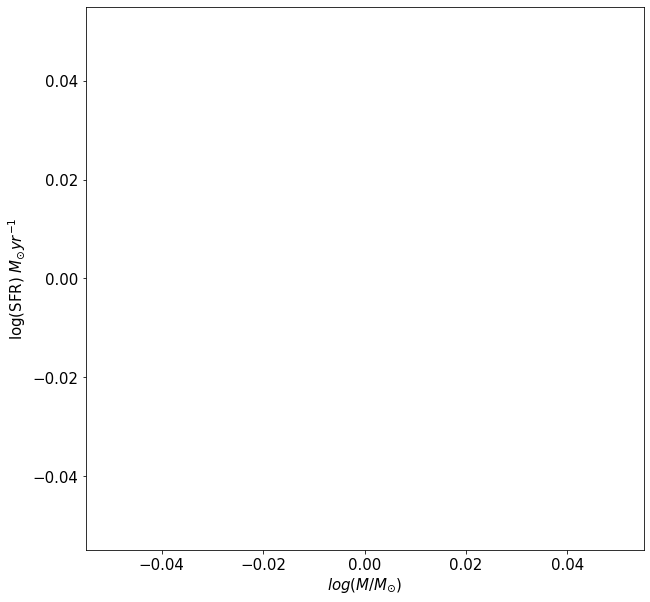

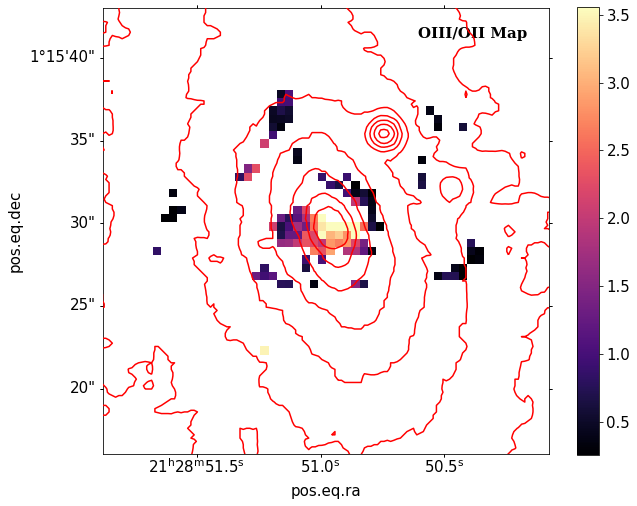

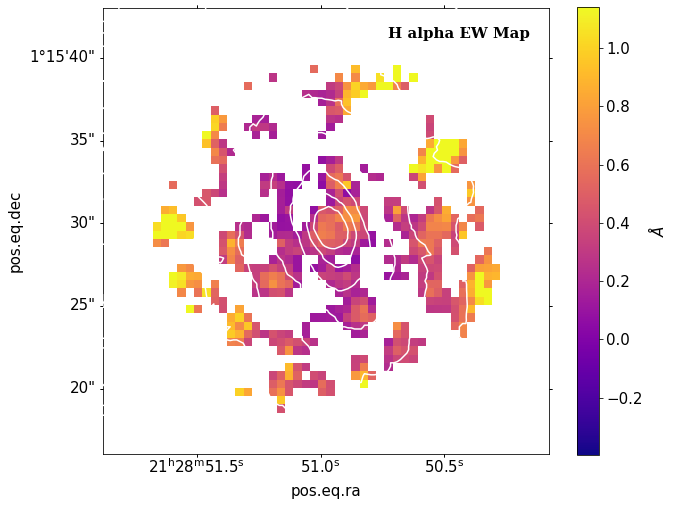

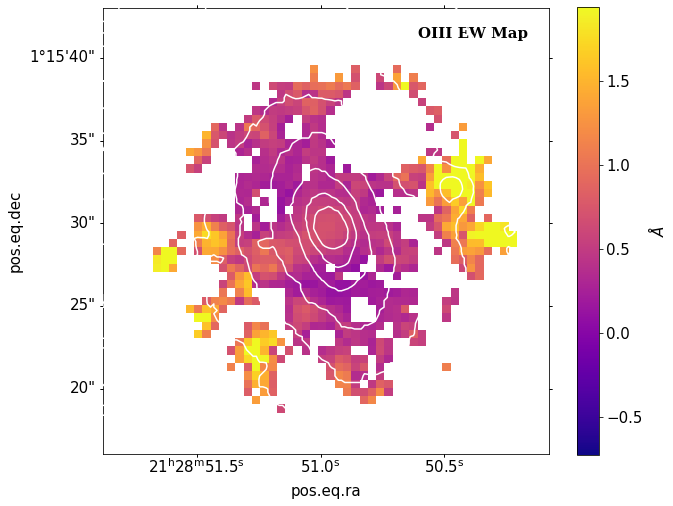

In [6]:
download = 0
sfr_all = []
for plateifu in ['9045-3701', '9042-3702', '8616-6103']:
    if not os.path.exists(f'S0_maps/{plateifu}'):
        os.mkdir(f'S0_maps/{plateifu}')
  
    maps = Maps(plateifu=plateifu,mode='remote')
    mangaid=maps.mangaid
    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # Get SDSS Image
    optical=maps.getImage()

    # Optical Image
    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(projection=optical.wcs)
    ax1.grid(False)
    ax1.imshow(optical.data)
    ax1.grid(False)
    if download:
        fig.savefig(f'S0_maps/{plateifu}/SDSS',bbox_inches = 'tight',format='svg')
    
    # Crop Image to match IFU size
    optical.get_new_cutout(size,size)
    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    
  # H-alpha with optical contours
    fig = plt.figure(figsize = (10,10))
    ax3 = fig.add_subplot( projection=maps.wcs,slices=('x','y',0))
    ha = maps.emline_gflux_ha_6564

    ax3.grid(False)
    cbr = mapplot.plot(dapmap=ha,return_cbrange=True)
    img = ax3.imshow(goodspax(ha),vmin=cbr[0],vmax=cbr[1],cmap='jet')
    ax3.grid(False)
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    ax3.annotate(r'H alpha Map',(len(ha)-len(ha)/3.5,len(ha)-len(ha)/13),weight='bold',family='serif')
    cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
    cb.set_label(r'$1\times10^{-17}ergcm^{-2}s^{-1}$')
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')
    if download:
        fig.savefig(f'S0_maps/{plateifu}/H_alpha',bbox_inches = 'tight',format='svg')

    # grab the NII/Ha flux ratio, Ha and NII equivalent width arrays
    nii=maps.emli40ne_gflux_nii_6585
    ha=maps.emline_gflux_ha_6564
    niiha = nii/ha
    ewha = maps['emline_sew_ha_6564']
    ewnii = maps['emline_sew_nii_6585']
    # take the log of the NII/Ha ratio
    logniiha = np.log10(niiha.value)

    # create the WHAN categories
    psf = (logniiha < -0.4) & (ewha.value > 3)
    sagn = (logniiha > -0.4) & (ewha.value > 6)
    wagn = (logniiha > -0.4) & ((ewha.value > 3) & (ewha.value < 6))
    rg = ewha.value < 3
    pg = (ewha.value < 0.5) & (ewnii.value < 0.5) 

    # create a custom array for a WHAN categories (we copy the EW Ha array just to get a 2d-array of the original size)
    value = ewha.value.copy()
    value[psf]  = 1     # pure star-forming 
    value[sagn] = 2     # strong agn
    value[wagn] = 3     # weak agn
    value[rg]   = 4     # retired galaxies
    value[pg]   = 5     # passive galaxies

    # Set ivar to 0 where the SNR < 1
    niiha_low_snr = mapplot.mask_low_snr(niiha.value, niiha.ivar, snr_min=1)
    ewha_low_snr = mapplot.mask_low_snr(ewha.value, ewha.ivar, snr_min=1)
    ewnii_low_snr = mapplot.mask_low_snr(ewnii.value, ewnii.ivar, snr_min=1)
    low_snr = np.logical_or(niiha_low_snr, ewha_low_snr, ewnii_low_snr)

    ivar = ewha.value.copy()
    ivar[low_snr] = 0
    value[low_snr] = np.nan

    # Set the size of image cutout 
    scale = maps.wcs.to_header()['PC2_2']*3600
    size = 2*maps.wcs.to_header()['CRPIX1']*scale

    # WHAN IFU
    fig = plt.figure(figsize = (10,10))
    ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    ax2.grid(False)
    cmap = colors.ListedColormap(['red', 'blue', 'goldenrod', 'green', 'purple'])
    nocov = ewha.pixmask.get_mask('NOCOV',dtype=np.bool)
    mask = np.where(nocov==True,np.nan,1)
    #fig, ax2, cb = mapplot.plot(value=value, ivar=ivar, mask=nocov, cmap=cmap,fig=fig,ax=ax2, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
    img = ax2.imshow(value,cmap=cmap,vmin=0.5,vmax=5.5)
    ax2.grid(False)
    ax2.set_autoscale_on(False)
    ax2.annotate(r'WHAN Map',(len(ha)-len(ha)/4,len(ha)-len(ha)/13),weight='bold',family='serif')

    filter_r=np.rot90(np.array(optical.data)[:,:,0].T )
    levels=[60.,  90., 120., 150., 180., 210., 240.]
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

    cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.825)
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['PSF', 'SAGN', 'WAGN', 'RG', 'PG'])
    ax2.set_xlabel('pos.eq.ra')
    ax2.set_ylabel('pos.eq.dec')
    
    if download:
        fig.savefig(f'S0_maps/{plateifu}/WHAN',bbox_inches = 'tight',format='svg')
    
    fig = plt.figure(figsize = (10,10))
    ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    m, f ,a = maps.get_bpt(show_plot=False)
    
    SF = sf= m['sf']['global'].astype('float64')*5
    COMP = m['comp']['global'].astype('float64')*4
    LIN = m['liner']['global'].astype('float64')*3
    SEY = m['seyfert']['global'].astype('float64')*2
    AMB = m['ambiguous']['global'].astype('float64')*1
    
    bpt = SF + COMP + LIN + SEY + AMB
    
    cmap = colors.ListedColormap(['grey','red', 'purple', 'green', 'cyan'])
    nocov = ewha.pixmask.get_mask('NOCOV')
    
    bpt[bpt==0]=np.nan
    
    #fig, ax4, cb = mapplot.plot(value=bpt, ivar = bpt, mask=nocov, cmap=cmap,fig=fig,ax=ax4, use_masks='NOCOV', return_cb=True, cbrange=(0.5, 5.5), title='')
    img = ax4.imshow(bpt,cmap=cmap,vmin=0.5,vmax=5.5)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)

    cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.825)
    cb.set_ticks([1, 2, 3, 4, 5])
    cb.set_ticklabels(['Ambiguous','Seyfert','LINER','Comp', 'SF'])
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')
    ax4.annotate(r'BPT Map',(len(ha)-len(ha)/4.6,len(ha)-len(ha)/12),weight='bold',family='serif')

    if download:
        fig.savefig(f'S0_maps/{plateifu}/BPT',bbox_inches = 'tight')
    plt.pause(0.05)
    
    
    fig = plt.figure(figsize = (10,10))
    ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    dn=maps.specindex_dn4000
    ax4.grid(False)
    cbr=mapplot.plot(dapmap=dn,return_cbrange=True)
    img = ax4.imshow(goodspax(dn),vmin=cbr[0],vmax=cbr[1],cmap='jet')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform=ax4.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb=plt.colorbar(img,ax=ax4,anchor=(0,5),shrink=0.824)
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')
    ax4.annotate(r'Dn 4000 Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
    if download:
        fig.savefig(f'S0_maps/{plateifu}/DN4000',bbox_inches = 'tight',format='svg')
        
    
    fig = plt.figure(figsize = (10,10))
    ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    nii = maps.emline_gflux_nii_6585
    n2 = nii/ ha
    logn2 = np.log10(n2)
    logoh = 8.90 + 0.57 * logn2

    mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
    min_snr = 3.
    mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
    mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

    mask =  (mask_bad_data | mask_nii_low_snr | mask_ha_low_snr).astype(np.bool)
    ax3.grid(False)
    cbr = mapplot.plot(dapmap=logoh,mask=mask,return_cbrange=True)
    mask = np.where(mask==True,np.nan,1)
    img = ax3.imshow(logoh.value*mask,vmin=cbr[0],vmax=cbr[1],cmap = 'viridis')
    ax3.grid(False)
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform=ax3.get_transform(optical.wcs), colors='red',levels=levels,zorder=11)
    cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.825,label= '12+log(O/H)')
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')
    ax3.annotate(r'N2 Metallicity Map',(len(ha)-len(ha)/2.5,len(ha)-len(ha)/13),weight='bold',family='serif')
    if download:
        fig.savefig(f'S0_maps/{plateifu}/Metallicity',bbox_inches = 'tight',format='svg')
        
    
    
    hb = maps.emline_gflux_hb_4862
    ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')
    ha_sf    = ha*sf
    hb_sf    = hb*sf
    ha_hb_sf = ha_hb*sf
    
    z = maps.dapall['z']

    fa = ha_sf*1e-17*pow(10,2.468*0.934*np.log10(ha_hb_sf.value/2.86))

    D_L = cosmo.luminosity_distance(z).to(u.cm)

    Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)

    SFR = 5.5e-42*Lha

    SFR = SFR.value*(u.solMass/u.year)

    ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)

    area = (ang_dist.value**2*maps.bin_area.value)

    area = area*(u.kpc**2)

    SFRD = SFR/area

    R = maps.spx_ellcoo_elliptical_radius.value
    R_e=float(maps.header['reff'])

    x = (R/R_e)
    y = SFRD
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot()
    ax.scatter(x,y)
    ax.set_xlabel(r'$R/R_e$')
    ax.set_ylabel('SFRD ' + r'$M_{\odot}kpc^{-2}yr^{-1}$')
    
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', width=2,direction="in")
    ax.tick_params(which='major', length=7,direction="in")
    ax.tick_params(which='minor', length=4, color='black',direction="in")
    
    if 0:
        fig.savefig(f'S0_maps/{plateifu}/SFRD',bbox_inches = 'tight',format='svg')
    
    
   # Specific SFR/ log M
    
    cube =  maps.getCube()
    M = cube.vacs.firefly._make_map('stellar_mass')
    
    mask = None
    mask = (M < -10) if not mask else mask
    masked_array = np.ma.array(M, mask=mask) #log(M)
    
    ssfr = SFR.value/10**(masked_array)
    ssfr = np.log10(ssfr)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))
    
    #fig, ax, cb = mapplot.plot(value=ssfr, ivar = ssfr, mask=nocov, fig=fig, ax= ax,cmap='RdYlBu_r', use_masks='NOCOV', return_cb=True)
    mask = mask.astype(np.bool)
    mask = np.where(mask==True,np.nan,1)
    ax.grid(False)
    img = ax.imshow(ssfr*mask, cmap = 'RdYlBu_r')
    ax.grid(False)
    ax.set_autoscale_on(False)
    ax.contour(filter_r, transform=ax.get_transform(optical.wcs), colors='black',levels=levels,zorder=11)
    
    # plot the colour bar
    cbar = fig.colorbar(img, ax=ax,anchor=(0,5),shrink=0.824)
    cbar.set_label(r'$log(sSFR (yr^{-1}))$')
    ax.set_xlabel('pos.eq.ra')
    ax.set_ylabel('pos.eq.dec')
    ax.annotate(r'sSFR Map',(len(ha)-len(ha)/4,len(ha)-len(ha)/13),weight='bold',family='serif')
    
    if download:
        fig.savefig(f'S0_maps/{plateifu}/sSFR',bbox_inches = 'tight',format='svg')
        
    x = masked_array
    y = ssfr
    
    data = np.where(np.isnan(SFR.value),0,SFR.value)
    
    
    sfr_all.append([np.log10(np.sum(data)),np.log10(np.sum(10**M))])
    
    
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot()
    ax.scatter(x,y)
    ax.set_xlabel(r'$\log(M/M_{\odot})$')
    ax.set_ylabel(r'$\log(sSFR (yr^{-1}))$')
    
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', width=2,direction="in")
    ax.tick_params(which='major', length=7,direction="in")
    ax.tick_params(which='minor', length=4, color='black',direction="in")
    
    if 0:
        fig.savefig(f'S0_maps/{plateifu}/sSFRvM',bbox_inches = 'tight')

    # SFR vs M    
    x = masked_array
    y = np.log10(SFR.value)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot()
    ax.scatter(x,y)
    ax.set_xlabel(r'$log(M/M_{\odot})$')
    ax.set_ylabel('log(SFR) ' + r'$M_{\odot}yr^{-1}$')
    
    if 0:
        fig.savefig(f'S0_maps/{plateifu}/SFRvsM',bbox_inches = 'tight',format='svg')
    # OIII/OII map
    OIII_OII= maps.getMapRatio('emline_gflux','oiii_5008','oii_3729')
    
    fig = plt.figure(figsize = (10,10))
    
    ax4 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    ax4.grid(False)
    cbr = mapplot.plot(dapmap = OIII_OII, return_cbrange = True)
    
    img = ax4.imshow(goodspax(OIII_OII),vmin=cbr[0],vmax=cbr[1],cmap = 'magma')
    ax4.grid(False)
    ax4.set_autoscale_on(False)
    ax4.contour(filter_r, transform = ax4.get_transform(optical.wcs), colors = 'red',levels = levels,zorder=11)
    cb=plt.colorbar(img, ax=ax4,anchor=(0,5),shrink=0.824)
    ax4.set_xlabel('pos.eq.ra')
    ax4.set_ylabel('pos.eq.dec')
    ax4.annotate(r'OIII/OII Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
    if download:
        fig.savefig(f'S0_maps/{plateifu}/OIII_OII',bbox_inches = 'tight',format='svg')
        
     # H alpha EW
    ewha = maps['emline_sew_ha_6564']
    fig = plt.figure(figsize = (10,10))
    ax2 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    ax2.grid(False)
    cbr=mapplot.plot(dapmap=ewha,return_cbrange=True)
    img = ax2.imshow(goodspax(ewha),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
    ax2.grid(False)
    ax2.set_autoscale_on(False)
    ax2.contour(filter_r, transform=ax2.get_transform(optical.wcs), colors='white',levels=levels,zorder=11)
    cb=plt.colorbar(img,ax=ax2,anchor=(0,5),shrink=0.824)
    ax2.set_xlabel('pos.eq.ra')
    ax2.set_ylabel('pos.eq.dec')
    ax2.annotate(r'H alpha EW Map',(len(ha)-len(ha)/2.7,len(ha)-len(ha)/13),weight='bold',family='serif')
    cb.set_label(r'$\AA$')
    if download:
        fig.savefig(f'S0_maps/{plateifu}/ewH_alpha',bbox_inches = 'tight')
        
    # OIII 5007 EW
    ewOIII = maps['emline_sew_oiii_5008']
    fig = plt.figure(figsize = (10,10))
    ax3 = fig.add_subplot(projection=maps.wcs,slices=('x','y',0))

    ax3.grid(False)
    cbr = mapplot.plot(dapmap = ewOIII ,return_cbrange = True)
    img = ax3.imshow(goodspax(ewOIII),vmin=cbr[0],vmax=cbr[1],cmap = 'plasma')
    ax3.grid(False)
    ax3.set_autoscale_on(False)
    ax3.contour(filter_r, transform = ax3.get_transform(optical.wcs), colors = 'white',levels = levels,zorder=11)
    cb=plt.colorbar(img,ax=ax3,anchor=(0,5),shrink=0.824)
    ax3.set_xlabel('pos.eq.ra')
    ax3.set_ylabel('pos.eq.dec')
    ax3.annotate(r'OIII EW Map',(len(ha)-len(ha)/3.3,len(ha)-len(ha)/13),weight='bold',family='serif')
    cb.set_label(r'$\AA$')
    if download:
        fig.savefig(f'S0_maps/{plateifu}/ewOIII',bbox_inches = 'tight',format='svg')

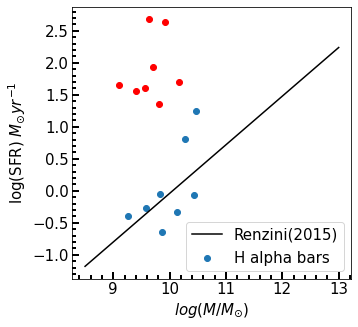

In [7]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
x = [9.86,10.46,10.27,9.27,10.14,10.44,9.83,9.58]
y = [-0.643,1.252, 0.812,-0.398,-0.323,-0.068,-0.048,-0.263]


ax.scatter(x,y)

data= np.array(sfr_all)
x = data[:,1]
y = data[:,0]
ax.scatter(x,y,color='red')
ax.set_xlabel(r'$log(M/M_{\odot})$')
ax.set_ylabel(r'log(SFR) $M_{\odot}yr^{-1}$')

x = np.linspace(8.5,13)

y = 0.76*x - 7.64
ax.plot(x,y,color='black')
#ax.set_xlim(8.5,12)
#ax.set_ylim(-4,2)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in")
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.legend(['Renzini(2015)','H alpha bars'])

5.165781159202519e+26

In [ ]:
data

# **SFRD**

In [ ]:
plateifu='8083-3702'# '8077-6104'
maps = Maps(plateifu=plateifu,mode='remote')

ha = maps.emline_gflux_ha_6564
hb = maps.emline_gflux_hb_4862
ha_hb = maps.getMapRatio('emline_gflux','ha_6564','hb_4862')

mask, fig, axes = maps.get_bpt(snr_min={'ha': 5, 'nii': 3, 'oi': 1},show_plot=False)
fig=plt.figure(figsize=(20,5))
ax=fig.subplots(1,3)

fig.suptitle("Maps")
mapplot.plot(dapmap=ha,fig=fig,ax=ax[0])
mapplot.plot(dapmap=hb,fig=fig,ax=ax[1])
mapplot.plot(dapmap=ha_hb,fig=fig,ax=ax[2])

ax[2].set_title('H-alpha/H-beta');

In [ ]:
sf = mask['sf']['global'].astype(int) # Star forming mask
ha_sf    = ha*sf
hb_sf    = hb*sf
ha_hb_sf = ha_hb*sf

fig=plt.figure(figsize=(20,5))
axn=fig.subplots(1,3)

fig.suptitle("Maps with Star forming mask")
mapplot.plot(dapmap=ha_sf,fig=fig,ax=axn[0])
mapplot.plot(dapmap=hb_sf,fig=fig,ax=axn[1])
mapplot.plot(dapmap=ha_hb_sf,fig=fig,ax=axn[2])

axn[0].set_title('Emission line Gaussian flux: H-alpha 6564')
axn[1].set_title('Emission line Gaussian flux: H-beta 4862')
axn[2].set_title('H-alpha/H-beta');

In [ ]:
z = maps.dapall['z']

fa = ha_sf*pow(10,2.468*0.934*np.log(ha_hb_sf.value/2.86))

D_L = cosmo.luminosity_distance(z).to(u.cm)

D_L = D_L.value

Lha =  (fa.value*4*np.pi*D_L*D_L)*(u.erg/u.second)*1e-17

SFR = 5.5e-42*Lha

SFR = SFR.value*(u.solMass/u.year)

ang_dist = Planck15.kpc_proper_per_arcmin(z).to(u.kpc/u.arcsec)

area = np.pi*(ang_dist.value**2*maps.bin_area.value)

area = area*(u.kpc**2)

SFRD=SFR/area

SFRD

R = maps.spx_ellcoo_elliptical_radius.value
R_e=float(maps.header['reff'])

x = (R/R_e)
y = SFRD

plt.scatter(x,y)
plt.xlabel(r'$R/R_e$')
plt.ylabel(y.unit)

In [ ]:
1/(1.8e41)

In [ ]:
img = plt.imshow(SFR.value)
plt.colorbar(img)

In [ ]:
mstar = Table.read('manga_firefly-v2_1_2.fits',hdu=1)

In [ ]:
mstar['PLATEIFU'==maps.plateifu]['PHOTOMETRIC_MASS']

In [ ]:
maps

# **Gas and Stellar Kinematics**

In [ ]:
havel = maps['emline_gvel_ha_6564']
stvel = maps['stellar_vel']

In [ ]:
diff = copy.deepcopy(stvel)
diff.setfield(havel.value - stvel.value,np.float64)
diff.ivar = 1. / ((1. / havel.ivar) + (1. / stvel.ivar))
diff.mask = havel.mask | stvel.mask

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax, map_ in zip(axes, [havel, stvel, diff]):
    mapplot.plot(dapmap=map_, fig=fig, ax=ax)
    if map_ is diff:
        ax.set_title('Ha vel - stellar vel')

In [ ]:
def stack_spectra(ind):
    # get a list of spaxels by passing a list of x-indices and a list of y-indices
    spaxels = maps.getSpaxel(x=ind[0], y=ind[1], xyorig='lower')

    # copy the first spaxel so that the stack is a Marvin Spaxel object
    stack = copy.deepcopy(spaxels[0])

    # overwrite the flux with the mean flux of the spectra in the stack (but keep the other meta-data)
    sps=[]
    for sp in spaxels:
        sp.load('cube')
        sps.append(sp.flux)
    stack.flux = np.mean(sps, axis=0)

    return stack

# Stack spectra with (Halpha vel - stellar vel) between -70 and -40
ind_neg = np.where((diff.value > -70) & (diff.value < -40))
stack_neg = stack_spectra(ind_neg)

# Stack spectra with (Halpha vel - stellar vel) between 40 and 70
ind_pos = np.where((diff.value > 40) & (diff.value < 70))
stack_pos = stack_spectra(ind_pos)

In [ ]:
stack_pos_adjusted = copy.deepcopy(stack_pos)
stack_pos_adjusted.flux /= 2
stack_pos_adjusted.load('cube')
stack_neg.load('cube')

In [ ]:
fig = plt.figure(figsize=(15, 4))
stack_pos_adjusted.cube_quantities['flux'].plot(figure=fig, return_figure=True)
stack_neg.cube_quantities['flux'].plot(figure=fig, return_figure=True);

In [ ]:
fig = plt.figure(figsize=(15, 4))
ax, fig = stack_pos_adjusted.cube_quantities['flux'].plot(figure=fig, return_figure=True,path_effects=None)
ax, fig = stack_neg.cube_quantities['flux'].plot(figure=fig, return_figure=True,path_effects=None)
ax.set_xlim([4050, 4100])
ax.set_ylim([0., 0.12])

In [ ]:
# zoom in on Halpha line
fig = plt.figure(figsize=(15, 4))
ax, fig = stack_pos_adjusted.cube_quantities['flux'].plot(figure=fig, return_figure=True)
ax, fig = stack_neg.cube_quantities['flux'].plot(figure=fig, return_figure=True)
ax.set_xlim([6850, 7200])
ax.set_ylim([0, 0.27])

# **Metallicity**

In [ ]:
plateifu='8138-6102'# '8077-6104'
maps = Maps(plateifu=plateifu,mode='remote')

ha = maps.emline_gflux_ha_6564
nii = maps.emline_gflux_nii_6585
n2 = nii/ ha
logn2 = np.log10(n2)
oh = 8.90 + 0.57 * logn2

In [ ]:
masks_bpt, __, __ = maps.get_bpt(show_plot=False)

mask_non_sf = ~masks_bpt['sf']['global']*n2.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_ha_low_snr

oh.plot(mask=mask,cblabel='12+log(O/H)');

In [ ]:
cb=mapplot.plot(dapmap=oh,mask=mask,return_cbrange=True)

In [ ]:
mask = mask_bad_data | mask_nii_low_snr | mask_ha_low_snr
mapplot.plot(dapmap=oh,mask=mask,cbrange=cb)

Image printer

In [ ]:
f = open('test.txt','a')
figure = '{figure}'
for plateifu in df.plateifu:
    url = '{Images/IMG/' + f'{plateifu}ap' +'}'
    a = f"\n\\begin{figure}[h!] \n     \centering\n    \includegraphics[width=0.8\columnwidth]{url}\n \end{figure}\n \\vspace"+"{-30pt}"
    f.write(a)
f.close()

In [ ]:
figure = '{figure}'
url = '{Images/' + f'{plateifu}' +'}'
a = f"\n\\begin{figure}[h!] \n     \centering\n    \includegraphics[width=1\columnwidth]{url}\n \end{figure}"
a

In [ ]:
f = open('test.txt','a')
f.write(a)
f.close()

In [ ]:
for plateifu in df_L.plateifu.values:
    maps = Maps(plateifu=plateifu,mode='remote')
    mask,fig,ax=maps.get_bpt(return_figure=True,show_plot=False)
    
    fig.savefig(f'{plateifu} BPT',bbox_inches = 'tight')
    plt.show()